# Expore data

## Import & definitions

In [ ]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_62136/2761487227.py:19: SyntaxWarning: invalid escape sequence '\.'
  title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)


## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
# keep target untouched
df_feat_raw[f"{TARGET_NAME}_raw"] = df_feat_raw[TARGET_NAME]
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_62136/2738736025.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2419.198618,2418.400385,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1196.32
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2419.198618,2418.400385,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1195.38
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2419.198618,2418.400385,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1194.55
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2419.198618,2418.400385,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1195.98
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2419.198618,2418.400385,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1196.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255033,1749040800000,2621.71,2625.30,2621.20,2624.51,1106.7394,2025-06-04 12:40:00,2641.525000,2635.690000,2630.360,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.51
255034,1749041100000,2624.50,2626.90,2623.30,2624.26,977.3830,2025-06-04 12:45:00,2641.525000,2635.690000,2630.360,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.26
255035,1749041400000,2624.26,2624.27,2617.15,2620.24,2446.9130,2025-06-04 12:50:00,2641.350000,2636.225000,2630.360,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2620.24
255036,1749041700000,2620.23,2621.73,2614.51,2616.73,2193.9711,2025-06-04 12:55:00,2641.350000,2636.225000,2629.695,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2616.73


### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH             1
vwap_z_score_BTC             1
ichi_tenkan_ETH              8
ichi_tenkan_BTC              8
rsi_h_ETH                   13
max_high_h_ETH              13
min_low_h_BTC               13
max_high_h_BTC              13
min_low_h_ETH               13
rsi_h_BTC                   13
chop_h_BTC                  14
chop_h_ETH                  14
ichi_kijun_ETH              25
ichi_cloud_a_ETH            25
ichi_kijun_BTC              25
ichi_cloud_a_BTC            25
ichi_tenkan_day_BTC        215
ichi_tenkan_day_ETH        215
dxy                        264
min_low_d_BTC              335
max_high_d_ETH             335
rsi_d_BTC                  335
max_high_d_BTC             335
rsi_d_ETH                  335
chop_d_ETH                 335
chop_d_BTC                 335
min_low_d_ETH              335
ichi_kijun_day_ETH         623
ichi_cloud_a_day_BTC       623
ichi_cloud_a_day_ETH       623
ichi_kijun_day_BTC         623
fvx                    

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.32
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.38
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1194.55
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.98
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255033,1749040800000,2621.71,2625.30,2621.20,2624.51,1106.7394,2025-06-04 12:40:00,2641.525000,2635.690000,2630.360,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.51
255034,1749041100000,2624.50,2626.90,2623.30,2624.26,977.3830,2025-06-04 12:45:00,2641.525000,2635.690000,2630.360,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.26
255035,1749041400000,2624.26,2624.27,2617.15,2620.24,2446.9130,2025-06-04 12:50:00,2641.350000,2636.225000,2630.360,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2620.24
255036,1749041700000,2620.23,2621.73,2614.51,2616.73,2193.9711,2025-06-04 12:55:00,2641.350000,2636.225000,2629.695,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2616.73


In [11]:
nb_missing = get_missing(df_feat)

missing data : 
date                2688
delta_event_real    2688
delta_event_pred    2688
Previous_num        2688
Consensus_num       2688
keep                2688
Date                2688
Previous            2688
Consensus           2688
Event               2688
Country             2688
Time (ET)           2688
Actual_num          2688
Actual              2688
dtype: int64

on 255038 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'Close_ETH_raw']

In [15]:
df_feat[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,...,vwap_3m_ETH,vwap_6m_ETH,vwap_y_ETH,vwap_all_ETH,vwap_z_score_ETH,nupl_ETH,supply_ETH,act_addr_ETH,market_dom_ETH,Close_ETH_raw
0,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2419.198618,2418.400385,1194.710,1194.710,...,1196.096667,1196.096667,1196.096667,1196.096667,-0.634018,0.000187,1.205290e+08,522460,17.409118,1196.32
1,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2419.198618,2418.400385,1194.710,1194.710,...,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,1.205290e+08,522460,17.409118,1195.38
2,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2419.198618,2418.400385,1194.710,1194.710,...,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,1.205290e+08,522460,17.409118,1194.55
3,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2419.198618,2418.400385,1194.710,1194.710,...,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,1.205290e+08,522460,17.409118,1195.98
4,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2419.198618,2418.400385,1194.710,1194.710,...,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,1.205290e+08,522460,17.409118,1196.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255033,2621.71,2625.30,2621.20,2624.51,1106.7394,2025-06-04 12:40:00,2641.525000,2635.690000,2630.360,2627.260,...,2215.946820,2112.080395,2465.963959,2449.429165,0.244601,0.066710,1.207159e+08,587140,9.110644,2624.51
255034,2624.50,2626.90,2623.30,2624.26,977.3830,2025-06-04 12:45:00,2641.525000,2635.690000,2630.360,2627.260,...,2215.970478,2112.079173,2465.992103,2449.429616,0.244251,0.066621,1.207159e+08,587140,9.110644,2624.26
255035,2624.26,2624.27,2617.15,2620.24,2446.9130,2025-06-04 12:50:00,2641.350000,2636.225000,2630.360,2627.260,...,2216.016378,2112.083189,2466.034614,2449.430717,0.238634,0.065188,1.207159e+08,587140,9.110644,2620.24
255036,2620.23,2621.73,2614.51,2616.73,2193.9711,2025-06-04 12:55:00,2641.350000,2636.225000,2629.695,2624.810,...,2216.072494,2112.088060,2466.071410,2449.431688,0.233729,0.063934,1.207159e+08,587140,9.110644,2616.73


In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

,fvx,spx,dxy
0,3.910,3823.179932,103.494003
1,3.910,3823.179932,103.494003
2,3.910,3823.179932,103.494003
3,3.910,3823.179932,103.494003
4,3.910,3823.179932,103.494003
...,...,...,...
255033,3.979,5970.529785,98.964996
255034,3.979,5970.529785,98.964996
255035,3.979,5970.529785,98.964996
255036,3.979,5970.529785,98.964996


In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Close_ETH_raw',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other +
    [f"{TARGET_NAME}_raw"]
)

# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  103


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [27]:
get_missing(df_feat.filter(list_col_select))

missing data : 
Series([], dtype: int64)

on 255038 samples


Series([], dtype: int64)

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [28]:
df_feat.shape[0]

255038

In [29]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

253763

In [30]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.32,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.38,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1194.55,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.98,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2419.198618,2418.400385,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255033,1749040800000,2621.71,2625.30,2621.20,2624.51,1106.7394,2025-06-04 12:40:00,2641.525000,2635.690000,2630.360,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.51,False
255034,1749041100000,2624.50,2626.90,2623.30,2624.26,977.3830,2025-06-04 12:45:00,2641.525000,2635.690000,2630.360,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.26,False
255035,1749041400000,2624.26,2624.27,2617.15,2620.24,2446.9130,2025-06-04 12:50:00,2641.350000,2636.225000,2630.360,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2620.24,False
255036,1749041700000,2620.23,2621.73,2614.51,2616.73,2193.9711,2025-06-04 12:55:00,2641.350000,2636.225000,2629.695,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2616.73,False


In [31]:
df_feat[df_feat["train"] == True]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2419.198618,2418.400385,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.32,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2419.198618,2418.400385,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.38,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2419.198618,2418.400385,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1194.55,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2419.198618,2418.400385,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.98,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2419.198618,2418.400385,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253759,1748658600000,2504.91,2505.00,2492.22,2495.20,4235.1902,2025-05-31 02:30:00,2528.067500,2546.470000,2505.22,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2495.20,True
253760,1748658900000,2495.21,2503.27,2494.44,2502.12,2576.0733,2025-05-31 02:35:00,2526.930000,2546.470000,2505.22,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2502.12,True
253761,1748659200000,2502.11,2502.60,2498.13,2498.60,1382.7143,2025-05-31 02:40:00,2525.150000,2546.470000,2505.22,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2498.60,True
253762,1748659500000,2498.60,2500.40,2496.37,2498.75,1450.5001,2025-05-31 02:45:00,2525.150000,2546.470000,2505.22,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2498.75,True


In [32]:
df_feat[df_feat["train"] == False]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw,train
253764,1748660100000,2492.49,2493.17,2487.12,2490.22,2272.6386,2025-05-31 02:55:00,2523.4350,2546.470,2501.755,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2490.22,False
253765,1748660400000,2490.21,2496.84,2489.04,2491.71,1715.3111,2025-05-31 03:00:00,2521.7675,2546.470,2501.600,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2491.71,False
253766,1748660700000,2491.71,2496.80,2485.23,2490.01,1743.7758,2025-05-31 03:05:00,2521.5525,2546.470,2501.600,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2490.01,False
253767,1748661000000,2490.00,2496.59,2488.06,2496.04,1652.4027,2025-05-31 03:10:00,2521.3800,2546.470,2501.600,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2496.04,False
253768,1748661300000,2496.04,2499.85,2486.99,2490.40,2457.9952,2025-05-31 03:15:00,2521.8325,2544.585,2501.600,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2490.40,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255033,1749040800000,2621.71,2625.30,2621.20,2624.51,1106.7394,2025-06-04 12:40:00,2641.5250,2635.690,2630.360,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.51,False
255034,1749041100000,2624.50,2626.90,2623.30,2624.26,977.3830,2025-06-04 12:45:00,2641.5250,2635.690,2630.360,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2624.26,False
255035,1749041400000,2624.26,2624.27,2617.15,2620.24,2446.9130,2025-06-04 12:50:00,2641.3500,2636.225,2630.360,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2620.24,False
255036,1749041700000,2620.23,2621.73,2614.51,2616.73,2193.9711,2025-06-04 12:55:00,2641.3500,2636.225,2629.695,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,2616.73,False


In [33]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):
    # Close ETH need to be in first place
    # we divide by close ETH price all price dependent features except the first Close ETH
    # in a matrix
    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                p_close = out_matrix[-1, 0] # last past history lag, first feature = Close ETH
                # scaling : price dependent features divide by Close ETH 
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / p_close
                )
                # keep Price Close with no scaling
                #out_matrix[-1, 0] = p_close
                
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [34]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [35]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [36]:
df_feat[df_feat["train"] == True].shape[0]

253764

In [37]:
df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET

253677

In [38]:
n_feat = df_feat.loc[df_feat["train"] == True, list_col_select].shape[1]
n_feat

103

In [39]:
# create X_train on disk
#filename = os.path.join(path_data, 'X_train.dat')
#print(filename)
X_train_dat = np.memmap(
    path_X_train, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [40]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [41]:
X_test = []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for index, seq in enumerate(gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        )):
        if is_train:
            # don't use append here but assign to X_train_dat
            X_train_dat[index] = seq # PAST_HISTORY * n_feat
            #X_train.append(seq)
        else:
            X_test.append(seq)
        
        #index += 1
    if is_train:
        X_train_dat.flush()

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

#X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

#print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1187, 72, 103) (1187, 15)


In [42]:
X_train_dat

memmap([[[1.0014901e+00, 1.0013311e+00, 1.0014901e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1963199e+03],
         [1.0007032e+00, 1.0014818e+00, 1.0017998e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [1.0000083e+00, 1.0007032e+00, 1.0010632e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         ...,
         [9.9983257e-01, 9.9962330e-01, 9.9984092e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1943400e+03],
         [9.9977398e-01, 9.9984092e-01, 9.9987441e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1942700e+03],
         [1.0000000e+00, 9.9978232e-01, 1.0001088e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945400e+03]],

        [[1.0002427e+00, 1.0010208e+00, 1.0013388e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [9.9954814e-01, 1.0002427e+00, 1.0006025e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         [1.0007447e+00, 9.9954814e-01, 1.0007447e+00, .

In [43]:
assert df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

In [44]:
X_train_dat.shape

(253677, 72, 103)

In [45]:
X_train_dat[0,:,:].shape

(72, 103)

In [46]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

In [47]:
X_train_dat[0,:,1]

memmap([1.0013311 , 1.0014818 , 1.0007032 , 1.0000083 , 1.0012054 ,
        1.0012724 , 1.0017413 , 0.99985766, 0.99973214, 0.9992466 ,
        1.000092  , 1.0002344 , 0.9996233 , 0.99964005, 1.0009711 ,
        1.0007032 , 1.0006949 , 1.0008874 , 1.0007617 , 1.0005022 ,
        1.000159  , 1.0003182 , 1.0008371 , 1.0006781 , 1.0012306 ,
        0.99972373, 0.9998493 , 1.0005609 , 1.0006614 , 1.0007032 ,
        1.0013311 , 1.0018417 , 1.0011386 , 1.0006195 , 1.0009376 ,
        1.0007617 , 1.0007284 , 0.99878615, 0.99918795, 0.99886984,
        0.9978318 , 0.99904567, 0.99903727, 0.99904567, 0.9994391 ,
        0.99954796, 0.99957305, 0.99986607, 0.9995898 , 0.9993721 ,
        0.998535  , 0.99840105, 0.9983006 , 0.99802434, 0.99802434,
        0.9980746 , 0.998602  , 0.99789876, 0.9980997 , 0.99825037,
        0.9986438 , 0.9990038 , 0.9988364 , 0.9989536 , 0.99891174,
        0.9991796 , 0.999707  , 0.9995228 , 0.99922985, 0.9996233 ,
        0.9998409 , 0.9997823 ], dtype=float32)

In [48]:
X_train_dat[0,:,-1]

memmap([1196.32, 1195.38, 1194.55, 1195.98, 1196.06, 1196.61, 1194.36,
        1194.22, 1193.64, 1194.64, 1194.82, 1194.09, 1194.1 , 1195.69,
        1195.38, 1195.38, 1195.6 , 1195.45, 1195.14, 1194.73, 1194.92,
        1195.53, 1195.35, 1196.02, 1194.21, 1194.37, 1195.22, 1195.33,
        1195.38, 1196.12, 1196.74, 1195.9 , 1195.27, 1195.66, 1195.45,
        1195.4 , 1193.09, 1193.57, 1193.2 , 1191.95, 1193.39, 1193.38,
        1193.41, 1193.86, 1194.  , 1194.04, 1194.39, 1194.04, 1193.79,
        1192.8 , 1192.64, 1192.51, 1192.18, 1192.18, 1192.25, 1192.87,
        1192.04, 1192.26, 1192.44, 1192.92, 1193.35, 1193.15, 1193.29,
        1193.25, 1193.57, 1194.18, 1193.96, 1193.61, 1194.1 , 1194.34,
        1194.27, 1194.54], dtype=float32)

## Standardization

In [49]:
path_scaler

'data/scaler.bin'

In [50]:
X_train_sca_dat = np.memmap(
    path_X_train_sca, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [51]:
list_col_select_global

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [52]:
# Peak memory : 17Gb !
# need to rescale minmax for some entries
list_min_max = ['day_off',
 'event_pred',
 'event_real']

if MODE_TRAIN_AE:
    scaler = StandardScaler()
    scaler.fit(X_train_dat.reshape(-1,X_train_dat.shape[-1]))
    for col in list_min_max:
        i_col = list_col_select.index(col)
        scaler.scale_[i_col] = 1
        scaler.mean_[i_col] = 0
    #X_train_sca_dat[:] = scaler.fit_transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)

    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [53]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99883363, 0.98687133, 0.99429154, ..., 0.99716965, 0.99328838,
        0.99604309],
       [0.98802374, 0.99545261, 0.99552833, ..., 0.99444827, 0.9972062 ,
        0.99580333],
       [1.00751892, 1.00759556, 1.00489698, ..., 1.00929377, 1.00787389,
        1.0079344 ]], shape=(253677, 15))

In [54]:
np.mean(y_train_sca)

np.float64(-6.796516874623723e-14)

In [55]:
np.std(y_train_sca)

np.float64(1.0)

In [56]:
np.mean(y_test_sca)

np.float64(0.04559068417215605)

In [57]:
np.std(y_test_sca)

np.float64(0.7247543709407388)

In [58]:
scaler.scale_

array([1.11758415e-02, 1.13341565e-02, 1.12647813e-02, 1.12758084e-02,
       1.58659704e-02, 1.69234305e-02, 1.21560721e-02, 1.15278091e-02,
       7.03027864e-02, 7.55225456e-02, 2.51978066e-02, 1.78609548e-02,
       1.79899755e-01, 1.86481614e-01, 6.00531676e-02, 3.71399331e-02,
       1.23344466e-02, 1.24286029e-02, 2.63323536e-02, 2.63300194e-02,
       6.16530272e-02, 5.58715498e-02, 1.16466161e-02, 1.19718808e-02,
       1.62849751e-02, 6.55955514e-02, 1.22452620e-01, 1.82853823e-01,
       8.65035270e-02, 1.98142910e-01, 9.58206494e+00, 9.59168327e+00,
       9.57255368e+00, 9.58205875e+00, 9.58213332e+00, 9.58036073e+00,
       9.58100748e+00, 9.58197494e+00, 9.62146355e+00, 9.59714636e+00,
       9.55135518e+00, 9.57274515e+00, 9.94294768e+00, 1.00965276e+01,
       9.41614582e+00, 9.52746475e+00, 9.62102516e+00, 9.54307203e+00,
       9.77353007e+00, 9.36669447e+00, 1.00480262e+01, 8.98767280e+00,
       9.58182442e+00, 9.58141669e+00, 9.57734737e+00, 9.47286938e+00,
      

In [59]:
scaler.scale_.shape

(103,)

In [60]:
scaler.scale_[-4:]

array([  1.        ,   1.        ,   1.        , 717.47630208])

In [61]:
scaler.mean_[-4:]

array([   0.        ,    0.        ,    0.        , 2419.09062826])

In [62]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

### Check unscaling

In [63]:
df_feat[list_col_select].head(10)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,Close_ETH_raw
0,1196.32,1196.13,1196.32,1195.65,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1196.32
1,1195.38,1196.31,1196.69,1194.90,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1195.38
2,1194.55,1195.38,1195.81,1194.55,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1194.55
3,1195.98,1194.55,1195.98,1194.31,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1195.98
4,1196.06,1195.98,1196.37,1195.97,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1196.06
5,1196.61,1196.06,1196.70,1196.06,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1196.61
6,1194.36,1196.62,1196.62,1193.72,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1194.36
7,1194.22,1194.37,1194.43,1192.72,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1194.22
8,1193.64,1194.22,1194.22,1193.02,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1193.64
9,1194.64,1193.64,1195.06,1193.63,2419.198618,2418.400385,1194.71,1194.71,2418.060398,2410.350542,...,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0,1194.64


In [64]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [65]:
X_train_sca_dat.shape

(253677, 72, 103)

In [66]:
np.testing.assert_array_almost_equal(
    scaler.inverse_transform(X_train_sca_dat[-1,-1,:].reshape(1,-1)).squeeze(),
    X_train_dat[-1,-1,:],
    decimal=5)

## Check Inputs TRAIN/TEST 

In [67]:
X_train_sca_dat[:,-1,:].shape

(253677, 103)

In [68]:
X_test[:,-1,:].shape

(1187, 103)

In [69]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca_dat[:,-1,:], np.ones((X_train_sca_dat.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,Close_ETH_raw,TRAIN
0,0.003863,-0.015292,-0.082240,0.083241,-0.036673,0.012806,-0.107057,-0.032204,14.569584,13.496038,...,1.365978,0.880986,-1.107987,1.388078,0.284506,0.0,0.0,0.0,-1.706747,1.0
1,0.003863,-0.035954,-0.091161,0.062472,-0.061043,-0.014380,-0.130058,-0.056495,14.556331,13.483742,...,1.414164,0.880986,-1.107987,1.388078,0.284506,0.0,0.0,0.0,-1.705981,1.0
2,0.003863,0.011297,-0.074811,0.089183,-0.056302,-0.009936,-0.119399,-0.031097,14.558501,13.485753,...,1.414164,0.880986,-1.107987,1.388078,0.284506,0.0,0.0,0.0,-1.706106,1.0
3,0.003863,0.071889,-0.023508,0.094373,-0.005289,0.035065,-0.056818,0.034977,14.580433,13.506105,...,1.414164,0.880986,-1.107987,1.388078,0.284506,0.0,0.0,0.0,-1.707374,1.0
4,0.003863,-0.055159,-0.089669,0.043907,-0.036263,-0.004498,-0.111838,-0.023114,14.561150,13.488213,...,1.414164,0.880986,-1.107987,1.388078,0.284506,0.0,0.0,0.0,-1.706259,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254859,0.003863,0.092026,0.079341,0.068936,0.105432,0.010549,0.232271,0.185398,-0.653008,-0.006914,...,0.366028,-0.314856,1.377693,0.948816,1.050286,0.0,0.0,0.0,0.298796,0.0
254860,0.003863,0.026366,-0.069311,-0.016969,0.103060,0.025358,0.237947,0.154305,-0.649606,-0.003601,...,0.366028,-0.314856,1.377693,0.948816,1.050286,0.0,0.0,0.0,0.297877,0.0
254861,0.003863,0.165733,0.070914,0.052666,0.199633,0.133503,0.346017,0.268111,-0.624761,0.020592,...,0.366028,-0.314856,1.377693,0.948816,1.050286,0.0,0.0,0.0,0.291173,0.0
254862,0.003863,-0.100039,-0.052764,-0.069291,0.124916,0.063534,0.240429,0.156868,-0.640835,0.004939,...,0.366028,-0.314856,1.377693,0.948816,1.050286,0.0,0.0,0.0,0.295507,0.0


In [70]:
df["event_real"].mean()

np.float64(1.9618306233912988e-05)

In [71]:
df["event_real"].std()

np.float64(0.0138657769553898)

#### SAve

In [72]:
df.to_csv(path_save_df_feat_std, index=False)

In [73]:
df[df["TRAIN"] == 1].describe()

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,Close_ETH_raw,TRAIN
count,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,...,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.000000,253677.0
mean,0.003863,0.003819,0.003891,0.003781,0.001458,0.001317,0.003542,0.003754,-0.001363,-0.001268,...,-0.000186,-0.000240,0.000020,0.000002,-0.000061,0.002957,0.000004,0.000020,0.000261,1.0
std,0.000000,0.166514,0.128898,0.131373,0.638363,0.688512,0.380625,0.242701,0.972563,0.976705,...,0.999941,1.000012,0.999992,1.000005,0.999999,0.054294,0.013898,0.013898,0.999800,0.0
min,0.003863,-5.116099,-0.091902,-7.984509,-7.300909,-6.986154,-6.596560,-5.580196,-3.855338,-3.569981,...,-1.414124,-1.273847,-1.381204,-1.413257,-1.413265,0.000000,-1.000000,-1.000000,-1.708448,1.0
25%,0.003863,-0.063221,-0.071034,-0.026482,-0.247243,-0.277757,-0.161263,-0.101731,-0.399892,-0.440495,...,-0.999931,-1.273847,-1.107987,-1.025499,-1.024320,0.000000,0.000000,0.000000,-0.839764,1.0
50%,0.003863,0.003550,-0.031963,0.040080,-0.001877,0.003434,0.009087,0.006637,-0.040914,-0.036834,...,0.000020,-0.314856,-0.001755,-0.069782,0.000015,0.000000,0.000000,0.000000,-0.179366,1.0
75%,0.003863,0.069218,0.033532,0.080344,0.237180,0.268948,0.172205,0.112400,0.285727,0.346492,...,0.999971,0.880986,1.104476,0.976888,1.024350,0.000000,0.000000,0.000000,0.904907,1.0
max,0.003863,8.303201,8.434505,0.103286,13.391198,13.445843,6.113667,5.187875,14.599020,13.523352,...,1.414164,1.413185,1.377693,1.417047,1.413294,1.000000,1.000000,1.000000,2.331393,1.0


In [74]:
df[df["TRAIN"] == 0].describe()

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,Close_ETH_raw,TRAIN
count,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,...,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.0,1187.0,1187.0,1187.000000,1187.0
mean,0.003863,0.001164,-0.001267,0.007113,-0.071876,-0.098014,-0.024533,-0.003600,0.244220,0.428947,...,0.022116,0.684706,-0.049403,1.258664,0.537090,0.0,0.0,0.0,0.191746,0.0
std,0.000000,0.125820,0.084316,0.087111,0.494191,0.498285,0.310941,0.186444,0.599465,0.290705,...,0.994721,0.647830,1.053707,0.150212,0.333506,0.0,0.0,0.0,0.070069,0.0
min,0.003863,-0.440208,-0.091902,-0.398262,-1.694651,-1.789058,-1.006730,-0.536961,-0.751890,-0.083843,...,-1.414124,-0.314856,-1.381204,0.948816,0.000015,0.0,0.0,0.0,0.082385,0.0
25%,0.003863,-0.073301,-0.063258,-0.035729,-0.341493,-0.338601,-0.237893,-0.132364,-0.398918,0.124060,...,-0.999931,-0.314856,-1.107987,1.146777,0.293852,0.0,0.0,0.0,0.136408,0.0
50%,0.003863,0.005585,-0.022363,0.030180,-0.019822,-0.047284,-0.010749,-0.000158,0.489683,0.491148,...,0.000020,0.880986,-0.001755,1.294700,0.574847,0.0,0.0,0.0,0.168074,0.0
75%,0.003863,0.078452,0.037270,0.072182,0.253608,0.229717,0.181375,0.123016,0.838479,0.686164,...,0.999971,0.880986,1.104476,1.386122,0.830720,0.0,0.0,0.0,0.266677,0.0
max,0.003863,0.741728,0.656495,0.103286,1.168894,1.131432,0.972224,0.647162,1.137881,0.927415,...,1.414164,1.413185,1.377693,1.417047,1.050286,0.0,0.0,0.0,0.320288,0.0


#### check out of range

In [75]:
df_min = df.groupby(df["TRAIN"]).min().transpose()
df_min

TRAIN,0.0,1.0
Close_ETH,0.003863,0.003863
Open_ETH,-0.440208,-5.116099
High_ETH,-0.091902,-0.091902
Low_ETH,-0.398262,-7.984509
ichi_cloud_a_ETH,-1.694651,-7.300909
...,...,...
day_in_month_sin,0.000015,-1.413265
day_off,0.000000,0.000000
event_pred,0.000000,-1.000000
event_real,0.000000,-1.000000


In [76]:
df_min["out_min"] = df_min[0] < (df_min[1] - 1e-6)
df_min


TRAIN,0.0,1.0,out_min
Close_ETH,0.003863,0.003863,False
Open_ETH,-0.440208,-5.116099,False
High_ETH,-0.091902,-0.091902,False
Low_ETH,-0.398262,-7.984509,False
ichi_cloud_a_ETH,-1.694651,-7.300909,False
...,...,...,...
day_in_month_sin,0.000015,-1.413265,False
day_off,0.000000,0.000000,False
event_pred,0.000000,-1.000000,False
event_real,0.000000,-1.000000,False


In [77]:
sum(df_min["out_min"].values)

np.int64(0)

In [78]:
df_max = df.groupby(df["TRAIN"]).max().transpose()
df_max

TRAIN,0.0,1.0
Close_ETH,0.003863,0.003863
Open_ETH,0.741728,8.303201
High_ETH,0.656495,8.434505
Low_ETH,0.103286,0.103286
ichi_cloud_a_ETH,1.168894,13.391198
...,...,...
day_in_month_sin,1.050286,1.413294
day_off,0.000000,1.000000
event_pred,0.000000,1.000000
event_real,0.000000,1.000000


In [79]:
df_max[0]

Close_ETH           0.003863
Open_ETH            0.741728
High_ETH            0.656495
Low_ETH             0.103286
ichi_cloud_a_ETH    1.168894
                      ...   
day_in_month_sin    1.050286
day_off             0.000000
event_pred          0.000000
event_real          0.000000
Close_ETH_raw       0.320288
Name: 0.0, Length: 103, dtype: float64

In [80]:
df_max[1]

Close_ETH            0.003863
Open_ETH             8.303201
High_ETH             8.434505
Low_ETH              0.103286
ichi_cloud_a_ETH    13.391198
                      ...    
day_in_month_sin     1.413294
day_off              1.000000
event_pred           1.000000
event_real           1.000000
Close_ETH_raw        2.331393
Name: 1.0, Length: 103, dtype: float64

In [81]:
df_max["out_max"] = df_max[0] > (df_max[1] + 1e-6)
df_max

TRAIN,0.0,1.0,out_max
Close_ETH,0.003863,0.003863,False
Open_ETH,0.741728,8.303201,False
High_ETH,0.656495,8.434505,False
Low_ETH,0.103286,0.103286,False
ichi_cloud_a_ETH,1.168894,13.391198,False
...,...,...,...
day_in_month_sin,1.050286,1.413294,False
day_off,0.000000,1.000000,False
event_pred,0.000000,1.000000,False
event_real,0.000000,1.000000,False


In [82]:
sum(df_max["out_max"].values)

np.int64(1)

In [83]:
df_max[df_max["out_max"] == True]

TRAIN,0.0,1.0,out_max
supply_BTC,1.422489,1.415529,True


In [84]:
nb_sample_test = df[df["TRAIN"] == False].shape[0]
print(nb_sample_test)
# min
def fun_min(value, col):
    return value < (df_min.at[col, 1] - 1e-6)
list_ser_col_min = []
for col in list_col_select:
    list_ser_col_min.append(df[df["TRAIN"] == False][col].apply(fun_min, args=(col,)))
df_count_min = pd.DataFrame(data=list_ser_col_min).transpose()


#pc_out_max = 100 * nb_out / nb_sample_test
#print(pc_out_max)
df_count_min

1187


,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,Close_ETH_raw
253677,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253678,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253679,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253680,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253681,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254859,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
254860,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
254861,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
254862,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [85]:
# max
def fun_max(value, col):
    return value > (df_max.at[col, 1] + 1e-6)
#nb_out = sum(df[df["TRAIN"] == False]["supply_BTC"].apply(fun_max, args=("supply_BTC",)))
list_ser_col_max = []
for col in list_col_select:
    list_ser_col_max.append(df[df["TRAIN"] == False][col].apply(fun_max, args=(col,)))
df_count_max = pd.DataFrame(data=list_ser_col_max).transpose()
df_count_max

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,Close_ETH_raw
253677,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253678,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253679,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253680,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
253681,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254859,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
254860,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
254861,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
254862,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [86]:
ser_min = df_count_min.apply(lambda x: 100*x.sum()/ x.shape[0])
ser_max = df_count_max.apply(lambda x: 100*x.sum()/ x.shape[0])
df_count = pd.DataFrame(data=[ser_min, ser_max], index=["pc_out_min", "pc_out_max"]).transpose()
df_count_out = df_count.loc[df_count["pc_out_min"] !=0 |(df_count["pc_out_max"] !=0) , :].transpose()
df_count_out

,supply_BTC
pc_out_min,0.000000
pc_out_max,84.667228


Text(0.5, 1.0, 'Percentage of TEST Out of range')

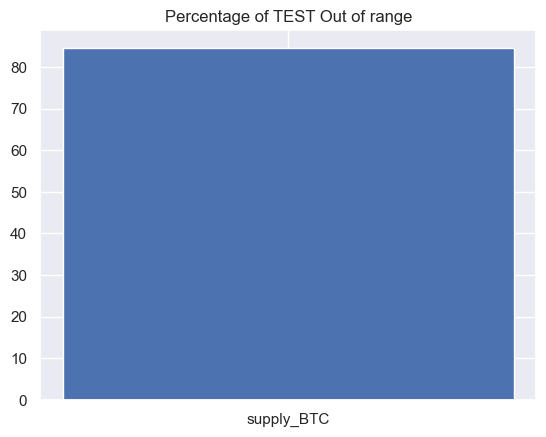

In [87]:
fig, ax = plt.subplots()
ax.bar(df_count_out.xs("pc_out_max").index.tolist(), df_count_out.xs("pc_out_max").values)
ax.bar(df_count_out.xs("pc_out_min").index.tolist(), -df_count_out.xs("pc_out_min").values)
ax.set_title("Percentage of TEST Out of range")

Text(0.5, 1.0, 'Features scaled boxplot')

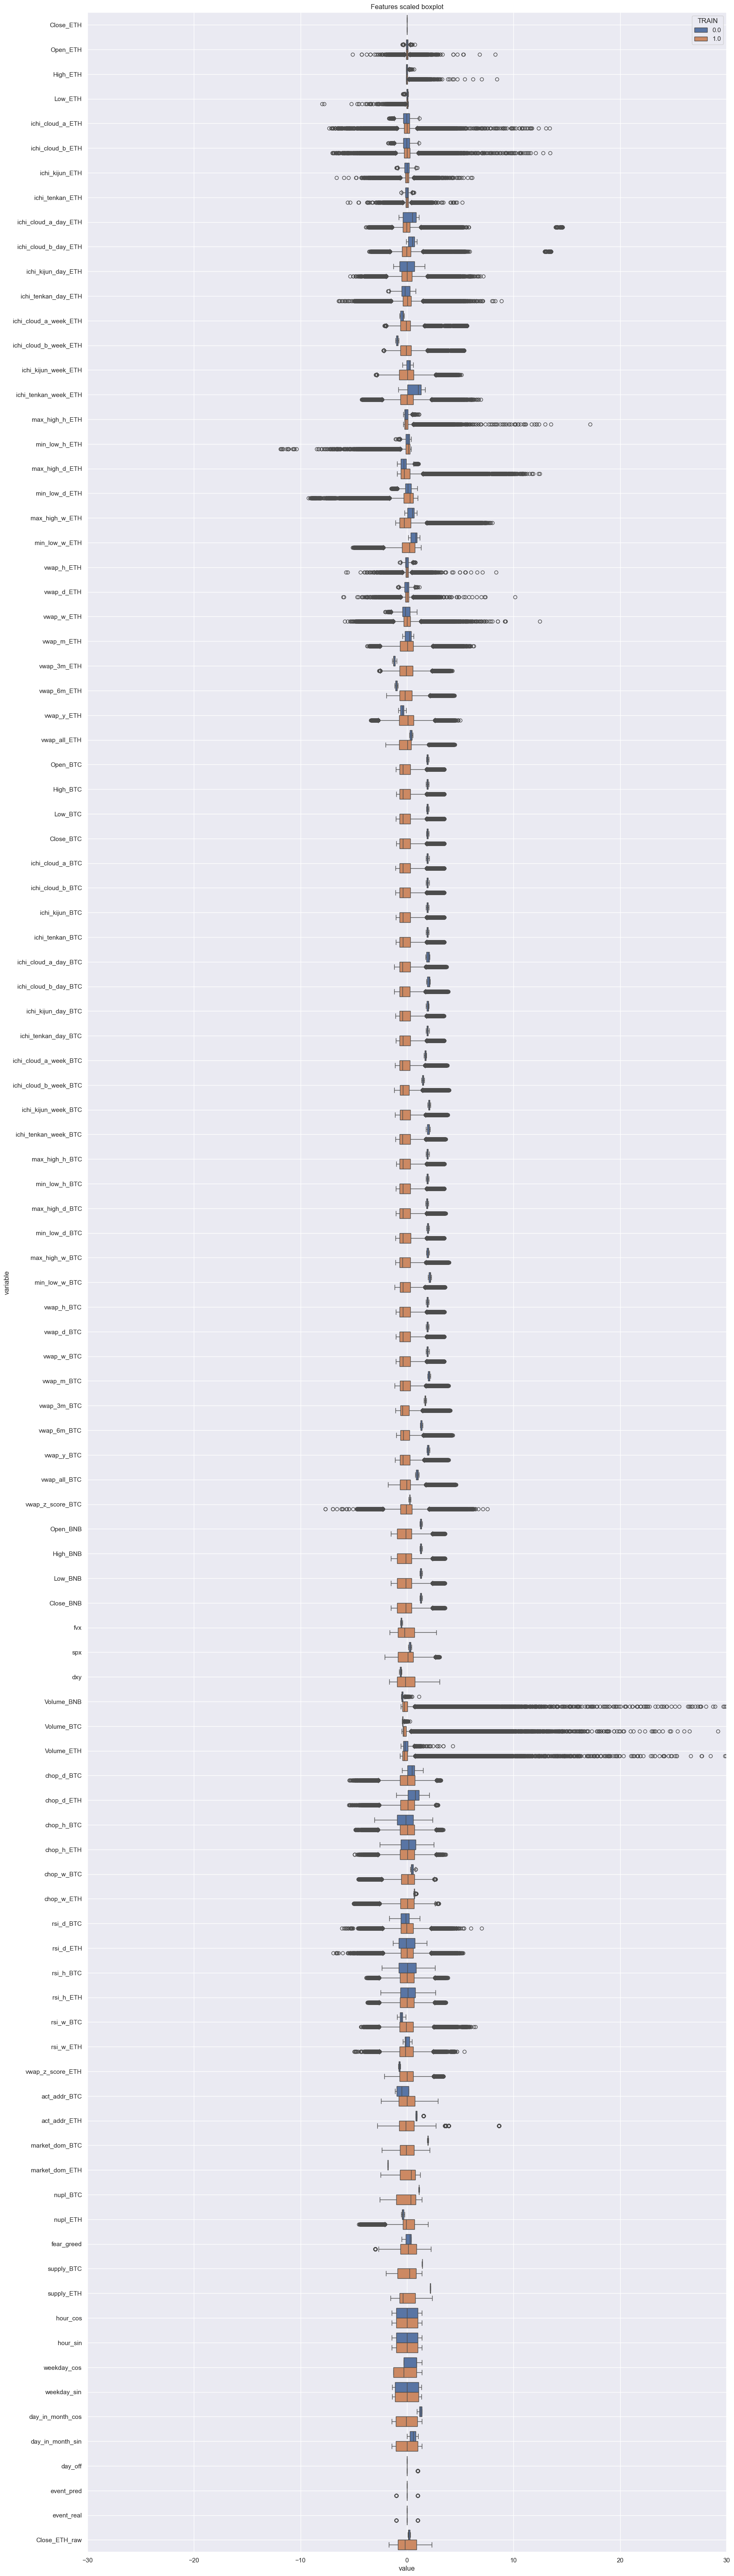

In [88]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

In [89]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0., 1.])

In [90]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()


array([0., 1.])

In [91]:
df_comp[(df_comp["TRAIN"] == False) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0.])

<Axes: >

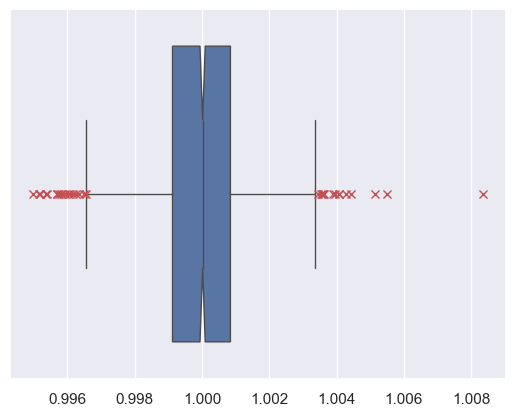

In [92]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_62136/4208190987.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


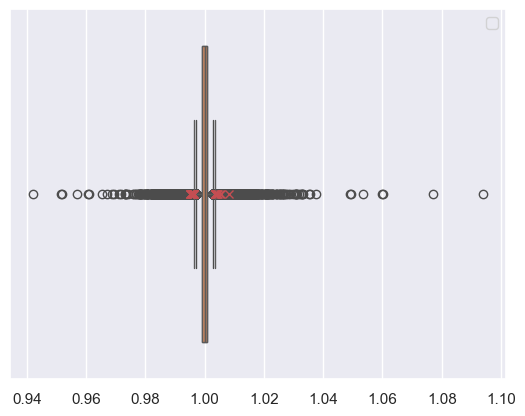

In [93]:
ax = sns.boxplot(
    x=X_train_dat[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

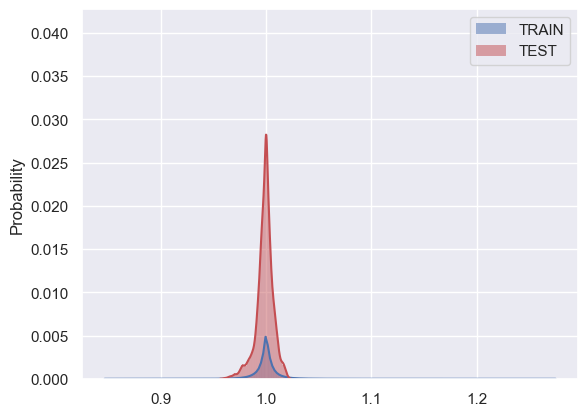

In [94]:

ax = sns.histplot(x=X_train_dat.reshape(-1, X_train_dat.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [ ]:
def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=5, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    return ser_val

def contingency_table(x, y, data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    and p value of independance
    '''
    c = data[[x,y]].pivot_table(index=x, columns=y, aggfunc=len)

    c = c.fillna(0) # on remplace les valeurs nulles par des 0

    chi2, p, dof, expected = stats.chi2_contingency(c)

    return c, chi2, p, dof, expected



def plot_cont(X, Y, data, liste_cat=None):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c, chi2, p, dof, expected = contingency_table(X, Y, data)
    print("expected: ", expected)
    
    tx = data[X].value_counts()
    ty = data[Y].value_counts()
    
    cont = c.copy()
    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    
    print(cont)

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n
    
    # calcul du signe (add-on)
    d_sign = (c-indep) / np.fabs(c-indep)
    
    mesure = d_sign * (c-indep)**2 / indep
    
    # patch sign
    xi_n = np.fabs(mesure).sum().sum()
    print("xi_n = ", xi_n)
    
    print("chi2: ", chi2)
    print("dof: ", dof)
    print("p: ", p)
    print(f"We have we have a {100*p:.4f}% chance for H0 to be true.")
    print("H0 : independance of distributions")
    print("H1 : distribution are not independant : we reject H0")
    # plot
    #print(c.shape)
    fig = plt.figure(figsize = (7/5*c.shape[1], 6/4*c.shape[0]))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f", center=0)
    ax = fig.gca()
    ax.set_title(Y + "= f( " + X + ")")
    plt.show()
    
    return c

In [141]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None, size=25):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

### Linear Corr

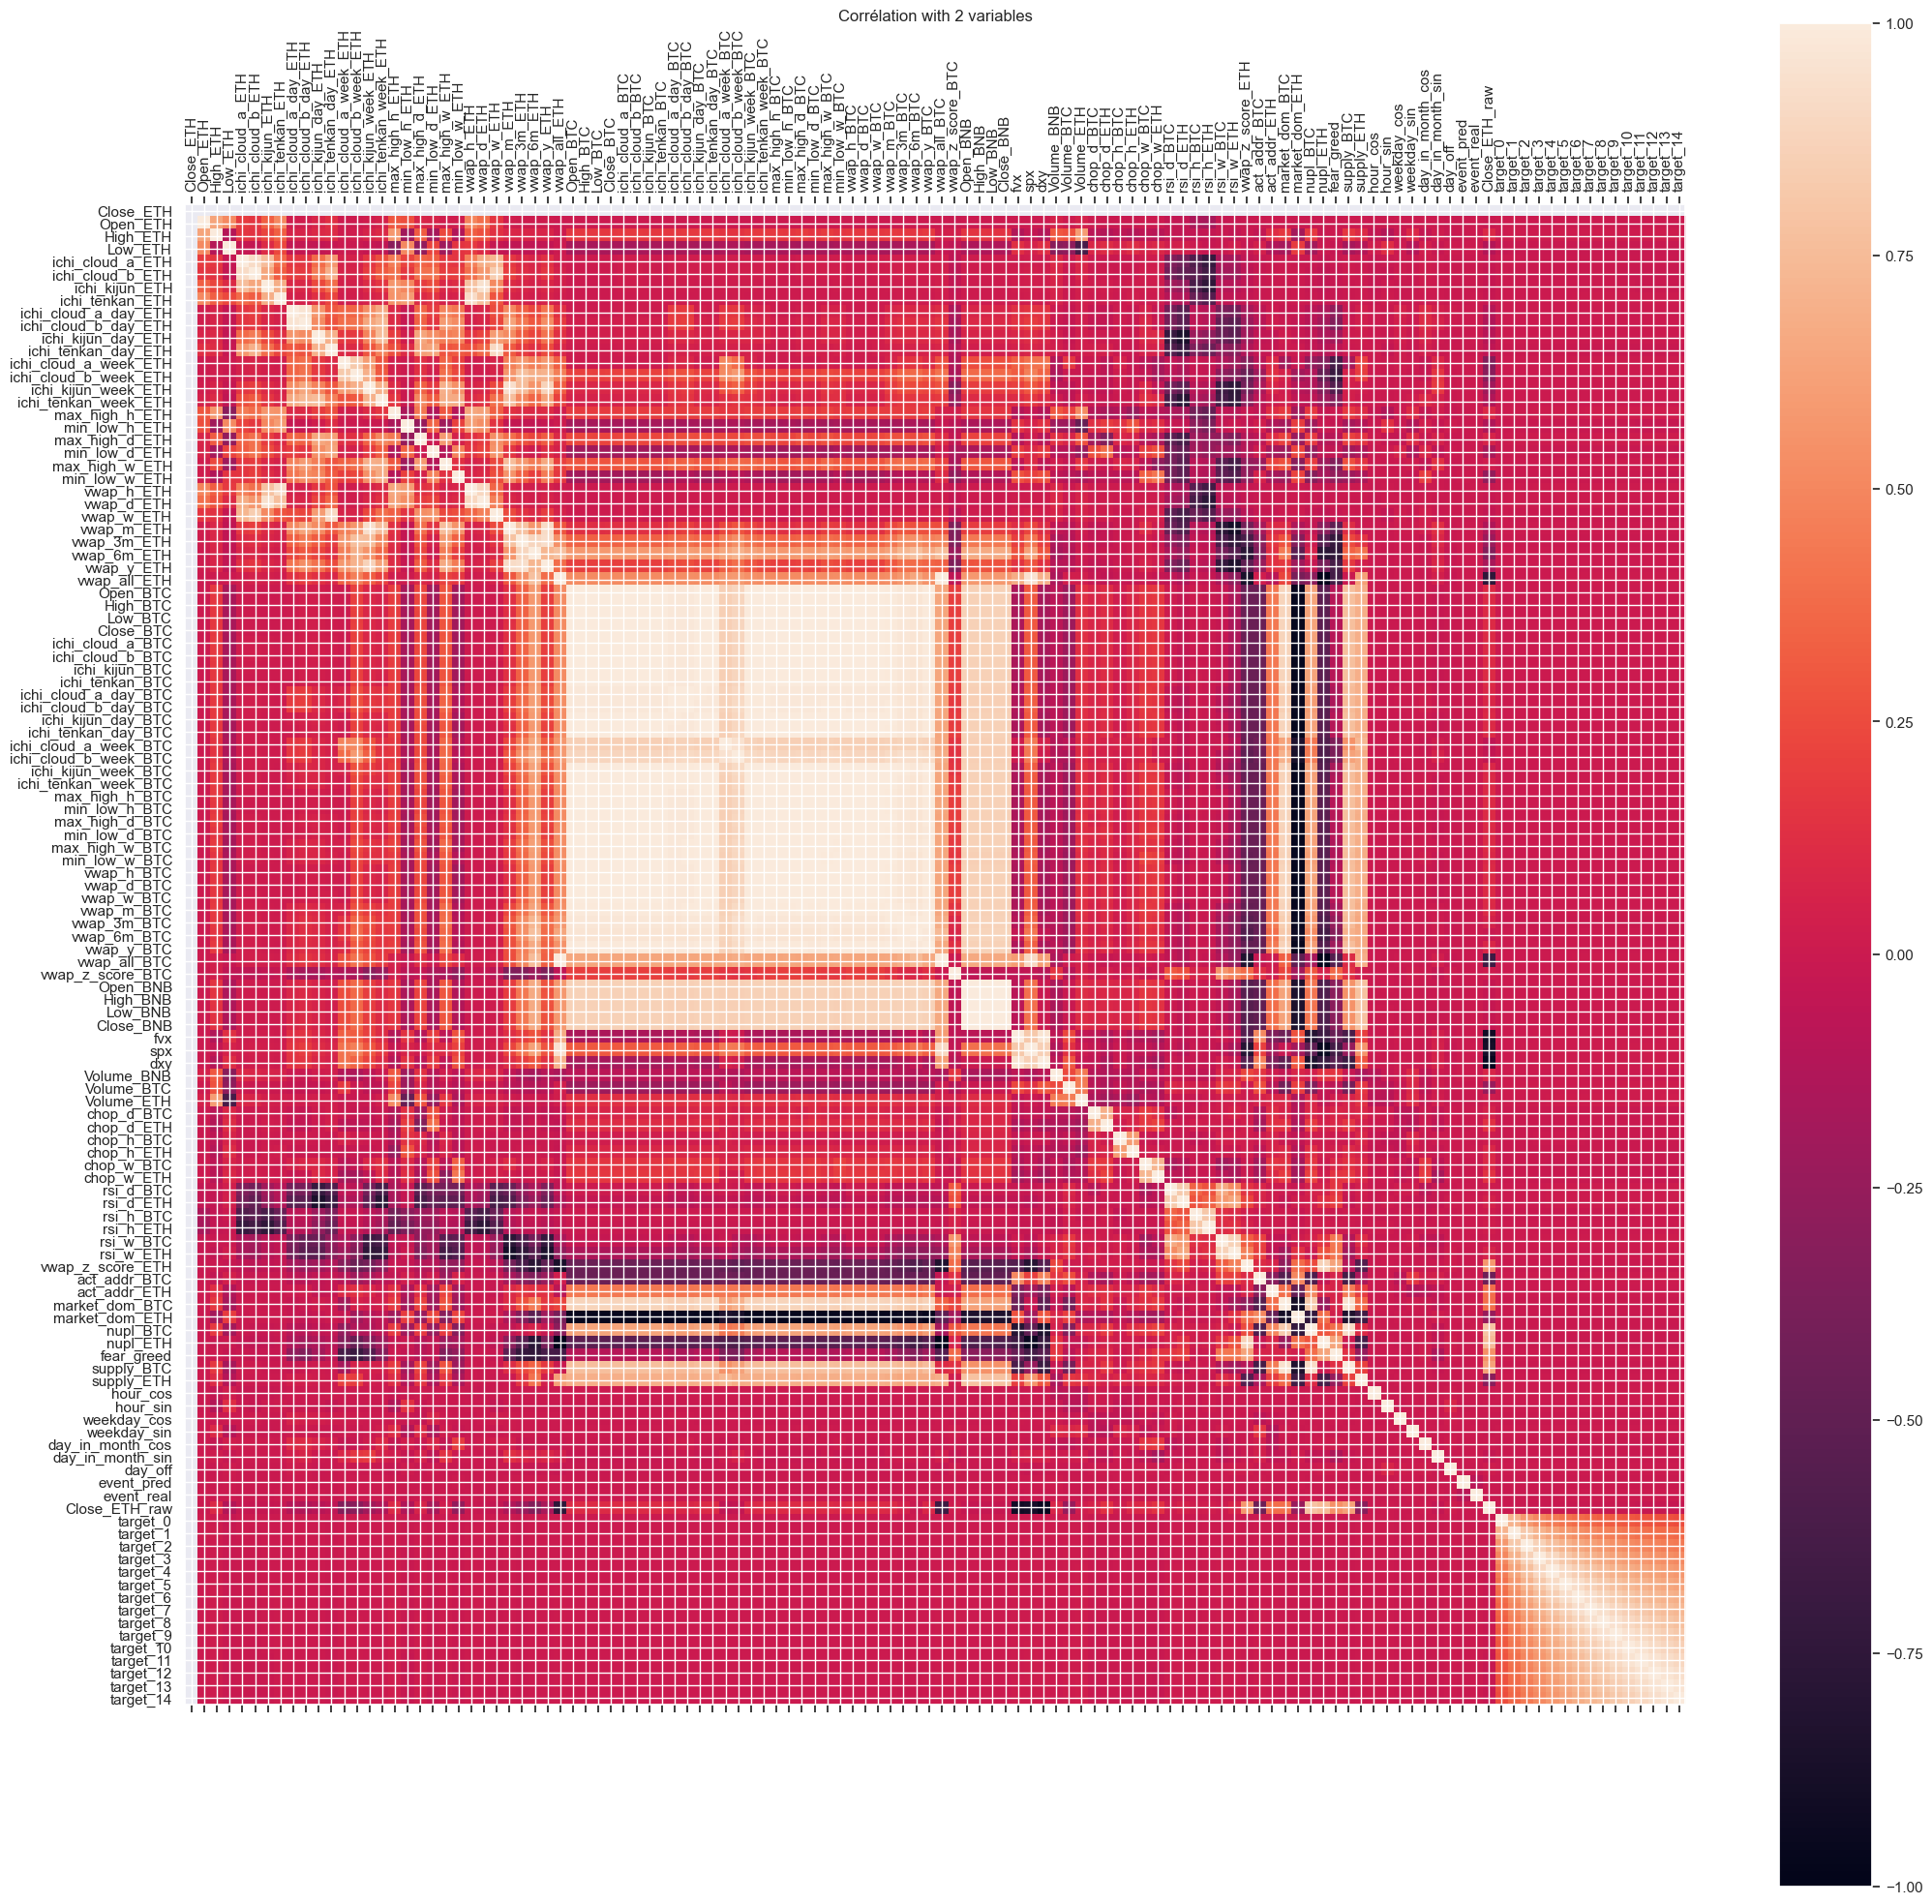

In [ ]:
nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_dat[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


In [351]:
y_train.shape

(253677, 15)

In [115]:

list_corr = []
for I_past in range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df = pd.DataFrame(np.hstack((X_train_dat[:, I_past, :nb_plot], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    # keep only correlation with targets
    corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
    # append dataframe to list
    list_corr.append(corr_matrix_targets)
arr_corr_matrix_targets = np.array(list_corr)
arr_corr_matrix_targets.shape

(72, 103, 15)

In [352]:
df.shape

(253677, 124)

In [ ]:
max_corr = np.max(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
max_corr_matrix_targets = pd.DataFrame(max_corr, columns=corr_matrix_targets.columns, index=corr_matrix_targets.index)
max_corr_matrix_targets

(103, 15)

In [128]:
min_corr = np.min(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
min_corr_matrix_targets = pd.DataFrame(min_corr, columns=corr_matrix_targets.columns, index=corr_matrix_targets.index)
min_corr_matrix_targets

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14
Close_ETH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open_ETH,-0.001701,-0.002949,-0.004338,-0.004786,-0.005536,-0.006069,-0.006341,-0.006946,-0.007559,-0.008070,-0.008769,-0.009670,-0.010539,-0.011152,-0.011719
High_ETH,-0.000797,-0.002178,-0.003831,-0.004392,-0.004896,-0.005219,-0.005530,-0.006099,-0.006690,-0.007125,-0.007764,-0.008598,-0.009396,-0.010045,-0.010533
Low_ETH,-0.016817,-0.009355,-0.013130,-0.010434,-0.012921,-0.014196,-0.012469,-0.012652,-0.013120,-0.012089,-0.012053,-0.012555,-0.013287,-0.014501,-0.014519
ichi_cloud_a_ETH,-0.001333,-0.002698,-0.004206,-0.004785,-0.005420,-0.005741,-0.006049,-0.006704,-0.007392,-0.007962,-0.008725,-0.009675,-0.010512,-0.011161,-0.011769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
day_in_month_sin,-0.000398,-0.000557,-0.000692,-0.000797,-0.000877,-0.000949,-0.001011,-0.001072,-0.001131,-0.001170,-0.001207,-0.001238,-0.001268,-0.001295,-0.001330
day_off,-0.001658,-0.001925,-0.002138,-0.002449,-0.002720,-0.002928,-0.002984,-0.003063,-0.003417,-0.003756,-0.004137,-0.004513,-0.004813,-0.004936,-0.004976
event_pred,-0.007535,-0.007502,-0.007099,-0.006575,-0.007400,-0.007414,-0.008150,-0.008197,-0.007157,-0.007306,-0.006725,-0.006705,-0.006893,-0.006448,-0.006236
event_real,-0.006934,-0.005017,-0.006066,-0.006793,-0.007159,-0.006455,-0.006324,-0.005582,-0.005122,-0.005386,-0.005777,-0.005484,-0.005540,-0.005085,-0.005007


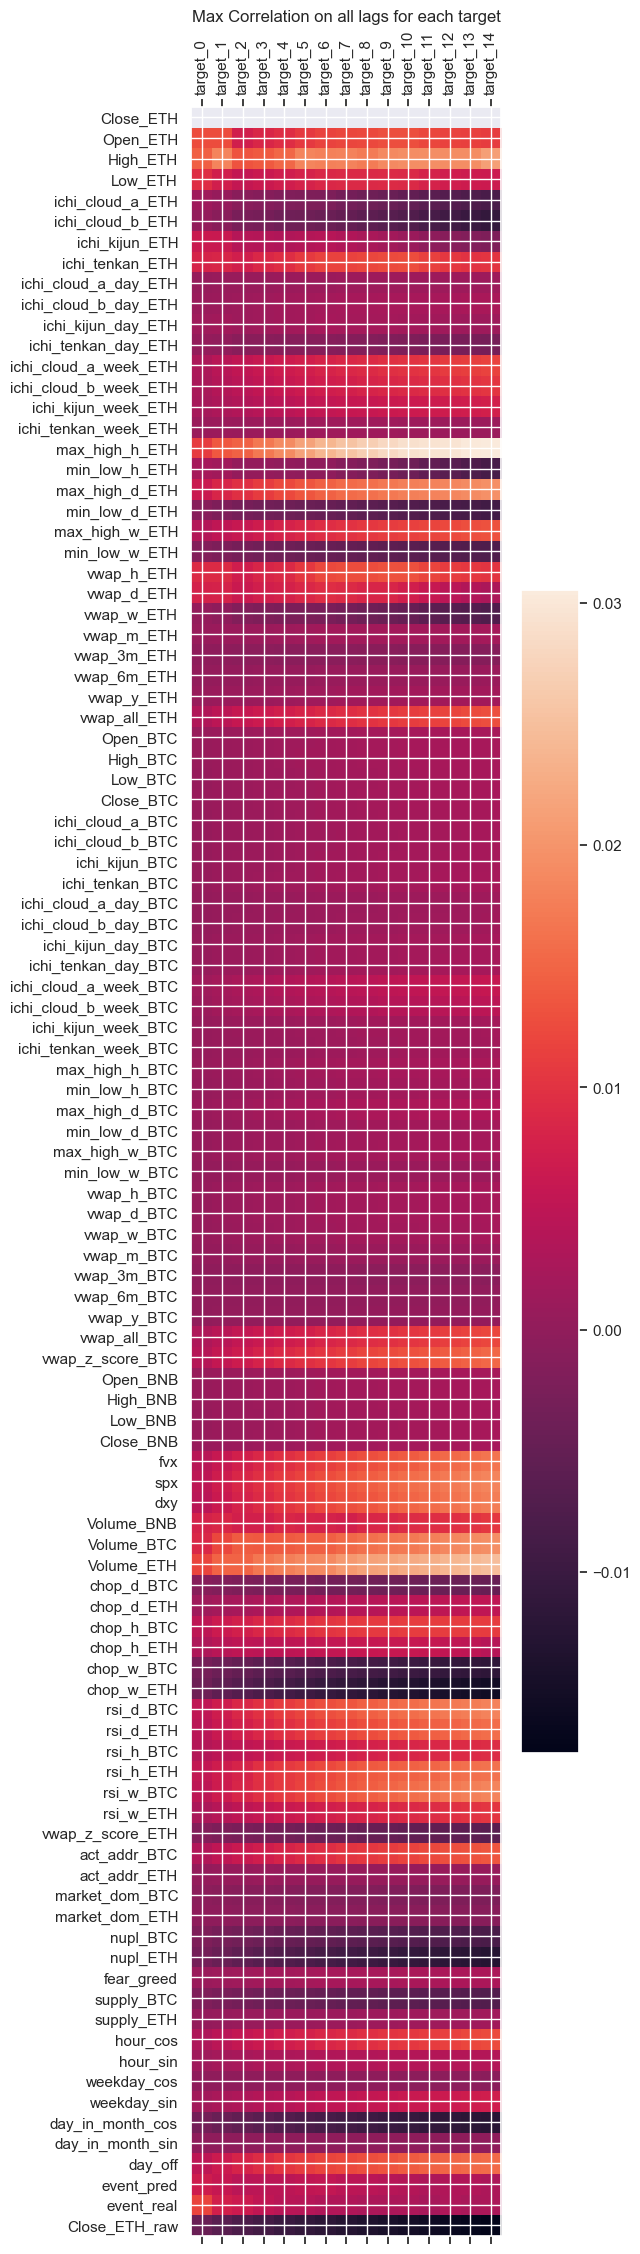

In [145]:
#corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(max_corr_matrix_targets, title = "Max Correlation on all lags for each target", size=5)

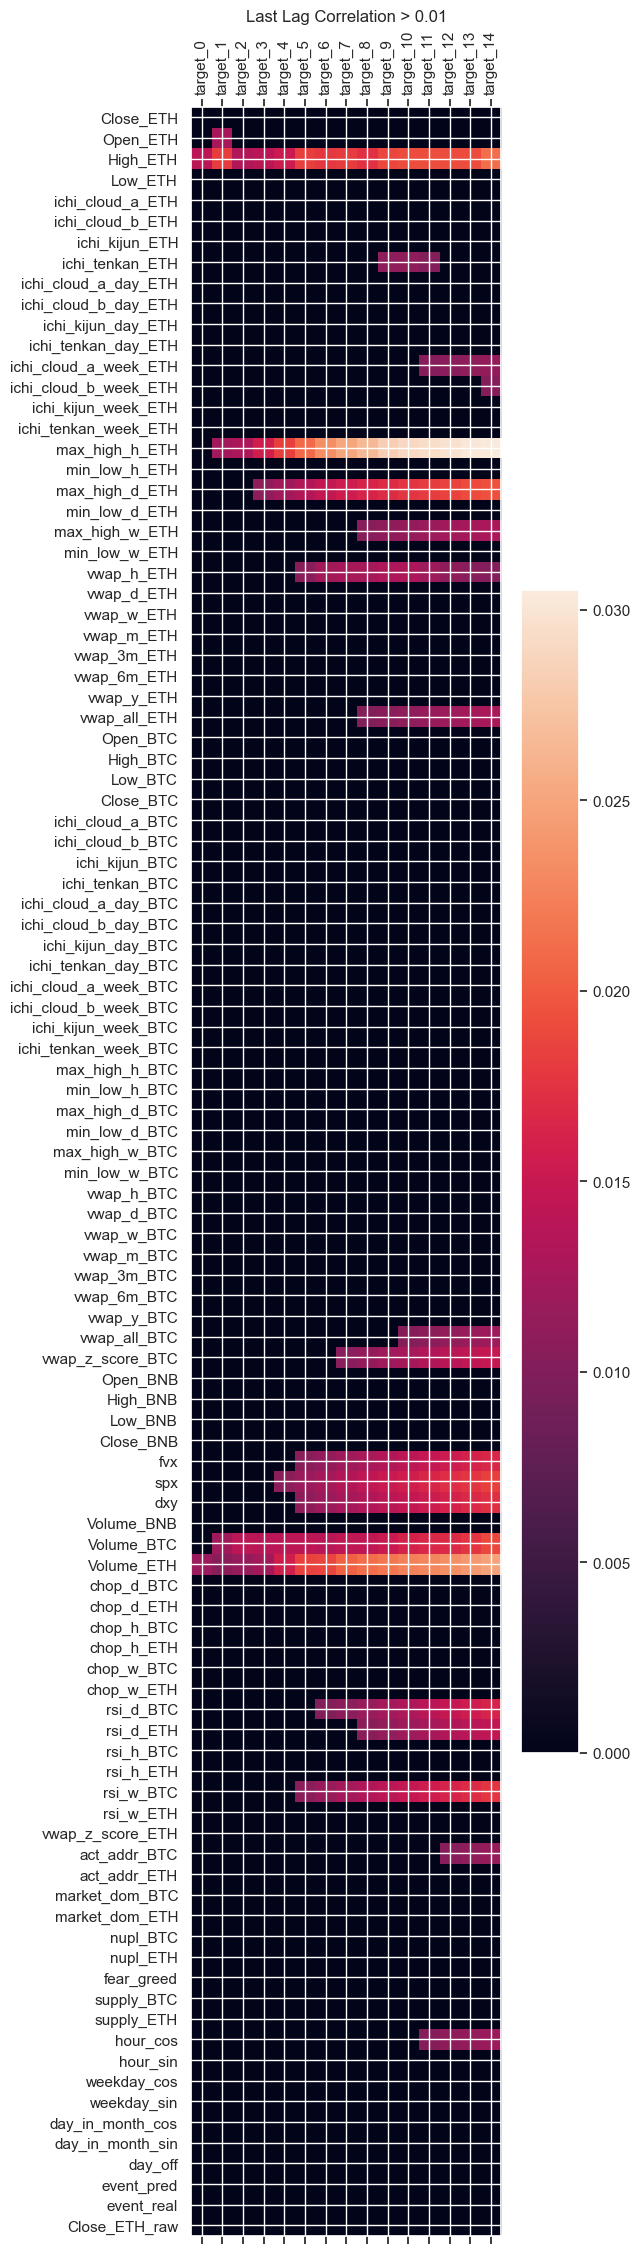

In [144]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.01, 0), 
    title = "Last Lag Correlation > 0.01", 
    size=5)

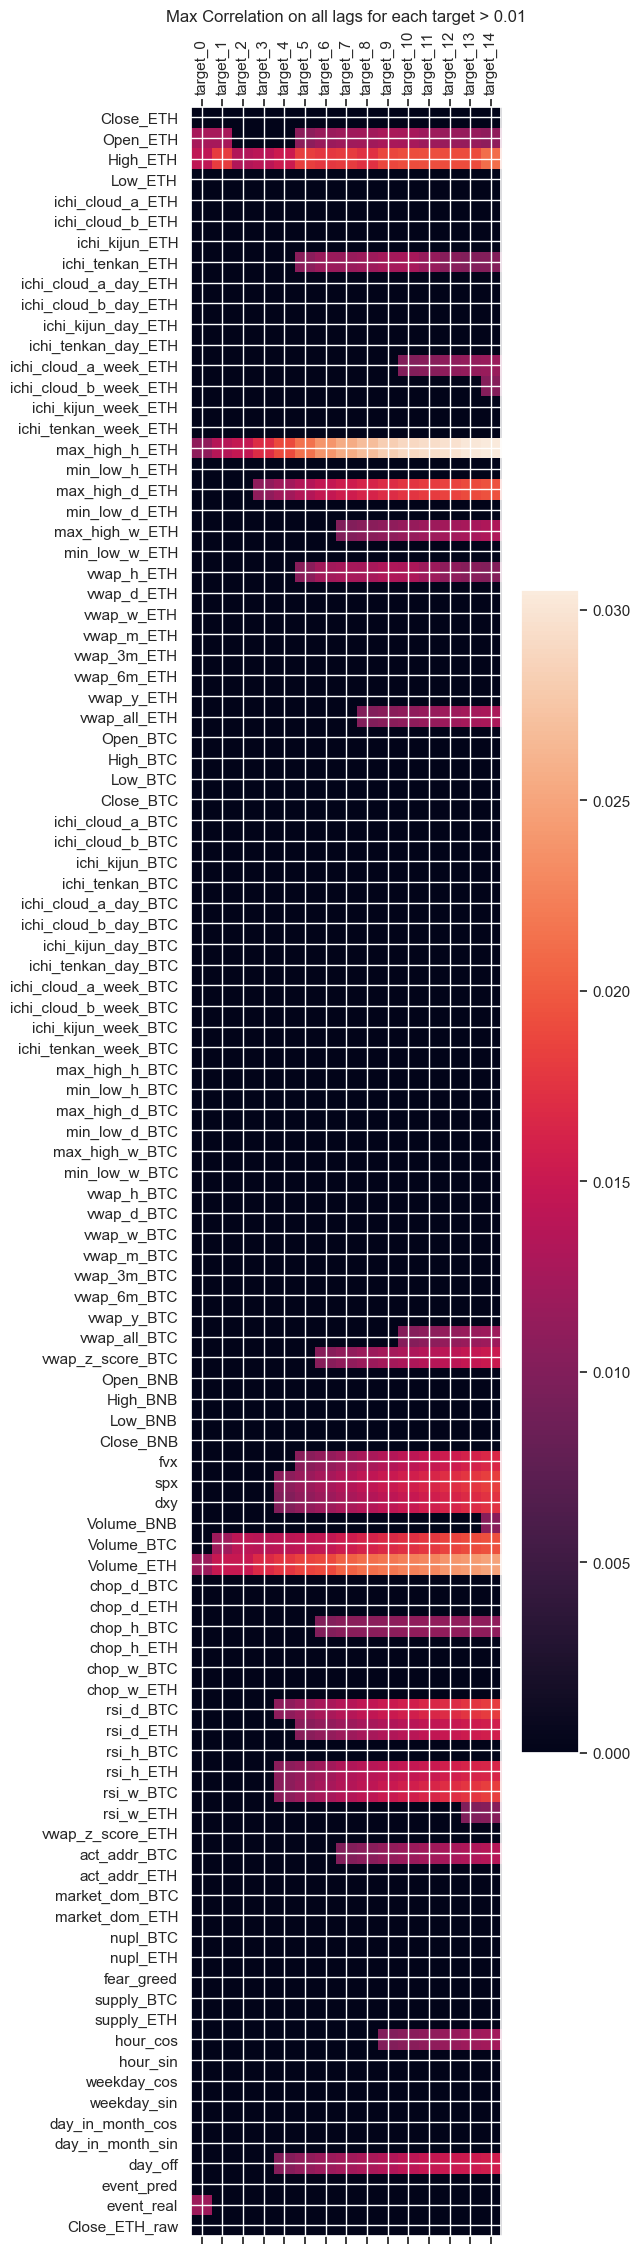

In [147]:
fig = plot_corr(
    max_corr_matrix_targets.where(max_corr_matrix_targets>0.01, 0),
    title="Max Correlation on all lags for each target > 0.01",
    size=5)

<Axes: >

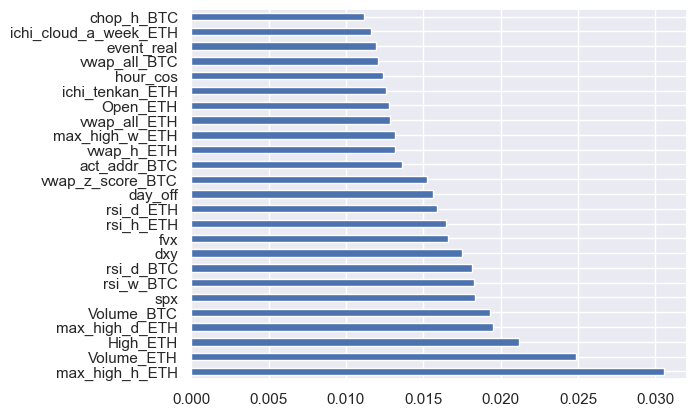

In [178]:
max_max_corr = max_corr_matrix_targets.max(axis=1).sort_values(ascending=False)
max_max_corr[max_max_corr.values>0.011].plot.barh()

In [274]:
df["target_cat"] = "neutral"
df.loc[df["target_14"] >= 1 + 0.5/100, "target_cat"] = "up"
df.loc[df["target_14"] <= 1 - 0.5/100, "target_cat"] = "down"
df["target_cat"].value_counts()

target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_62136/2612964428.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

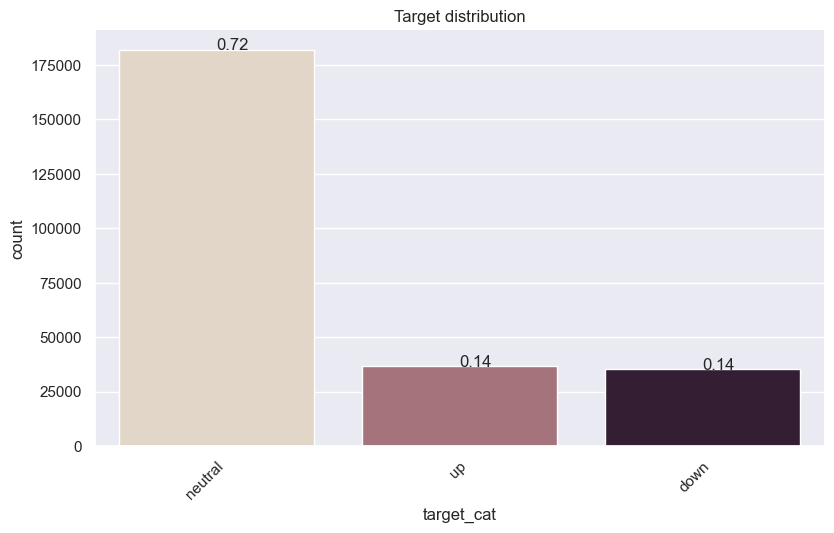

In [275]:
plot_hist_cat("target_cat", df, "Target distribution")

In [289]:
list_level=["neutral", "higher", "very-higher"]
df["max_high_h_ETH_cat"] = "very-higher"
df.loc[df["max_high_h_ETH"] <= 1.01, "max_high_h_ETH_cat"] = "higher"
df.loc[df["max_high_h_ETH"] <= 1.005, "max_high_h_ETH_cat"] = "neutral"

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_62136/2612964428.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


max_high_h_ETH_cat
neutral        179399
higher          50855
very-higher     23423
Name: count, dtype: int64

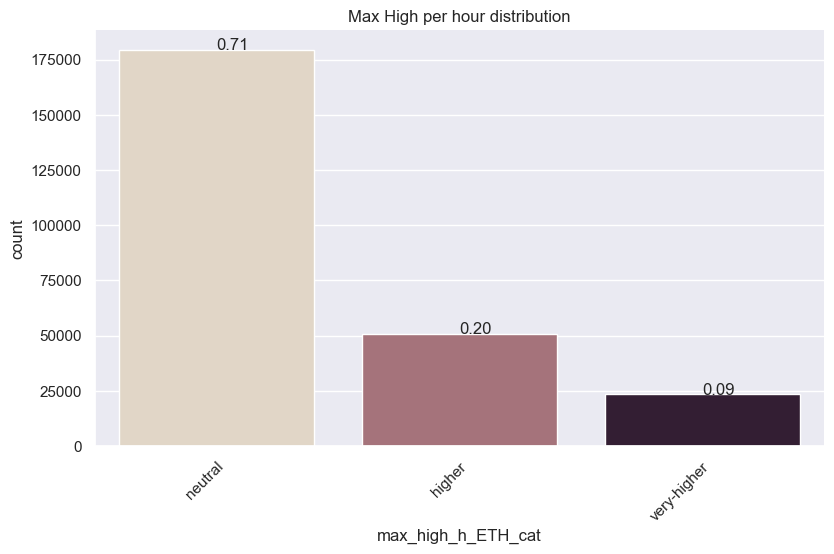

In [290]:
plot_hist_cat("max_high_h_ETH_cat", df, "Max High per hour distribution")

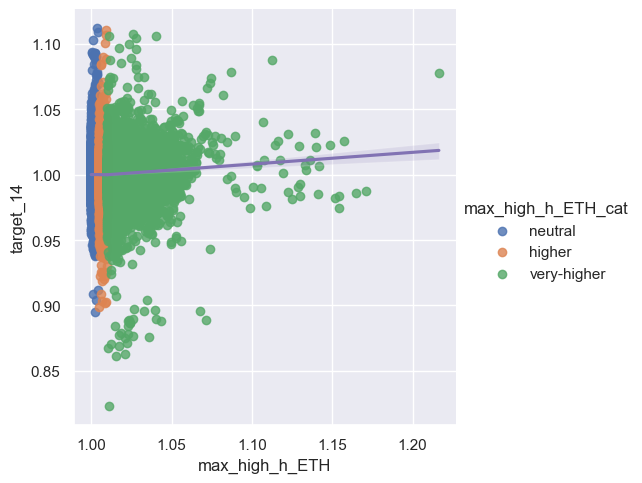

In [291]:
sns.lmplot(x="max_high_h_ETH", y="target_14",
            hue="max_high_h_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

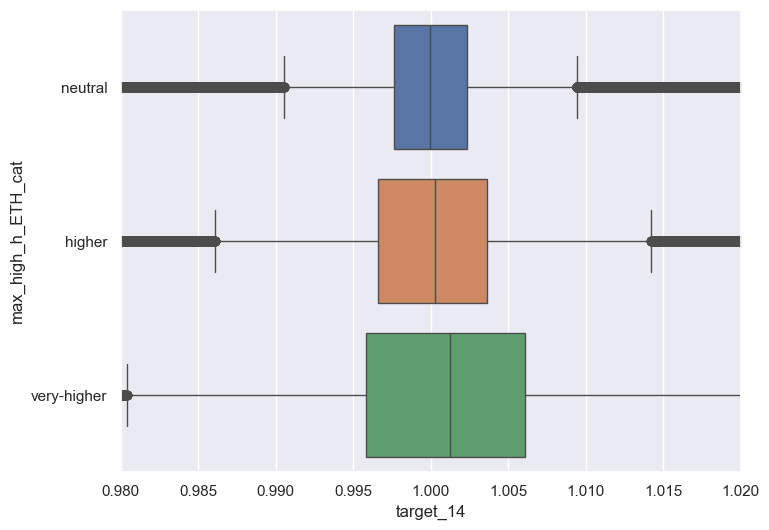

In [294]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="max_high_h_ETH_cat", 
    hue="max_high_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


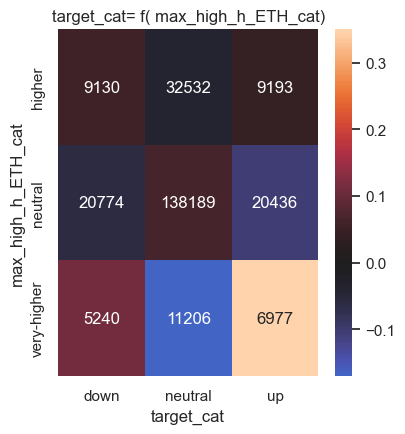

target_cat,down,neutral,up
max_high_h_ETH_cat,,,
higher,9130,32532,9193
neutral,20774,138189,20436
very-higher,5240,11206,6977


In [350]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


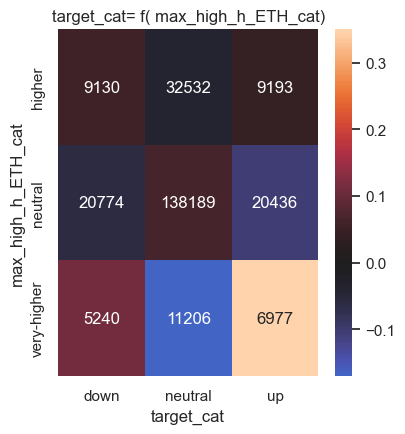

target_cat,down,neutral,up
max_high_h_ETH_cat,,,
higher,9130,32532,9193
neutral,20774,138189,20436
very-higher,5240,11206,6977


In [314]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

In [296]:
df["nupl_ETH"].describe()

count    253677.000000
mean          0.118971
std           0.198094
min          -0.775319
25%           0.039797
50%           0.106898
75%           0.260524
max           0.513805
Name: nupl_ETH, dtype: float64

In [ ]:

mquantiles(df["nupl_ETH"], prob=[0.10, 0.90])

array([-0.08284051,  0.36014272])

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_62136/2612964428.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


nupl_ETH_cat
neutral    168456
higher      69777
lower       15444
Name: count, dtype: int64

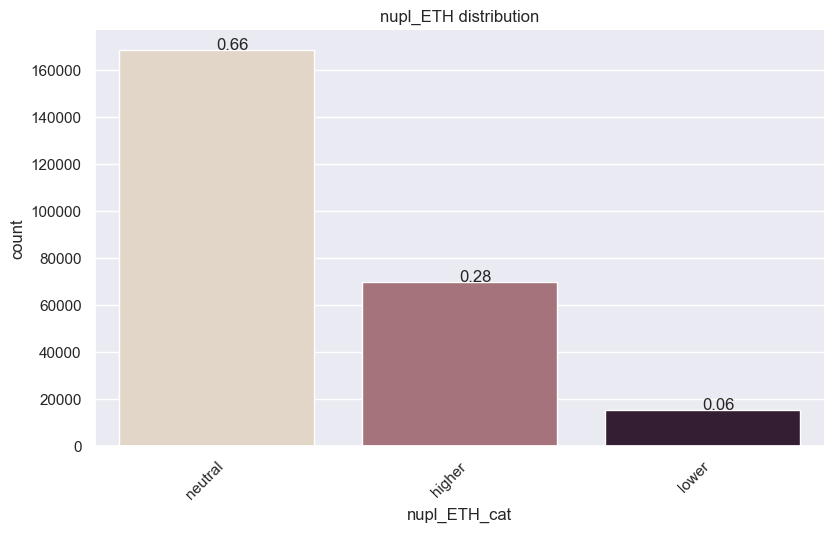

In [298]:

list_level=["lower", "neutral", "higher"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] >= 0.25, "nupl_ETH_cat"] = "higher"
df.loc[df["nupl_ETH"] <= -0.25, "nupl_ETH_cat"] = "lower"
plot_hist_cat("nupl_ETH_cat", df, "nupl_ETH distribution")

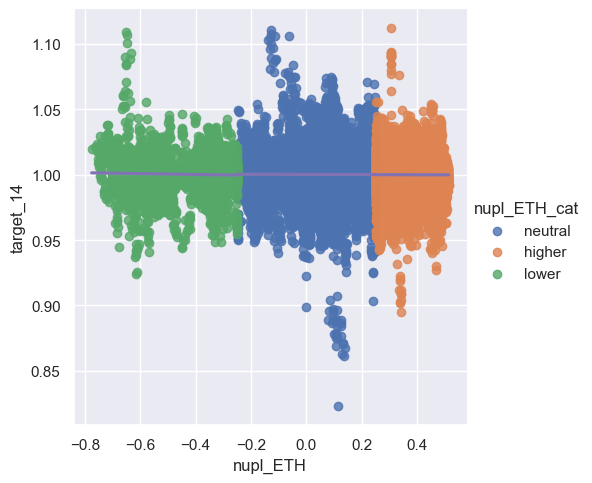

In [299]:
sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

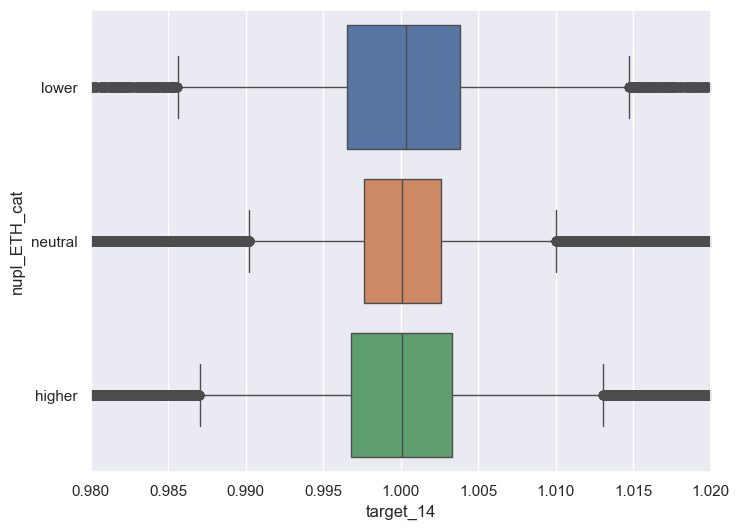

In [300]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

target_cat       down   neutral       up     Total
nupl_ETH_cat                                      
higher        11586.0   46564.0  11627.0   69777.0
lower          2817.0    9702.0   2925.0   15444.0
neutral       20741.0  125661.0  22054.0  168456.0
total         35144.0  181927.0  36606.0  253677.0
xi_n =  2159.047419759374
chi2:  2159.047419759374
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


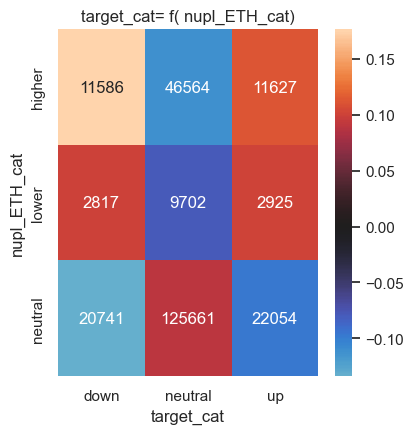

target_cat,down,neutral,up
nupl_ETH_cat,,,
higher,11586,46564,11627
lower,2817,9702,2925
neutral,20741,125661,22054


In [311]:
plot_cont(X="nupl_ETH_cat", Y="target_cat", data=df)

In [320]:
chi2 = 2159
indep = 35144.0/253677.0*69777.0
c = 11586
print("chi2: ", chi2)
print("indep: ", indep)
print("c: ", c)
print("chi2 abs part : ", (c-indep)**2/indep)
print("chi2 sign part : ", (c-indep) / np.fabs(c-indep))
print("% of chi2 : ", 100*(c-indep)**2/indep / chi2)


chi2:  2159
indep:  9666.79236982462
c:  11586
chi2 abs part :  381.03207215054994
chi2 sign part :  1.0
% of chi2 :  17.64854433305002


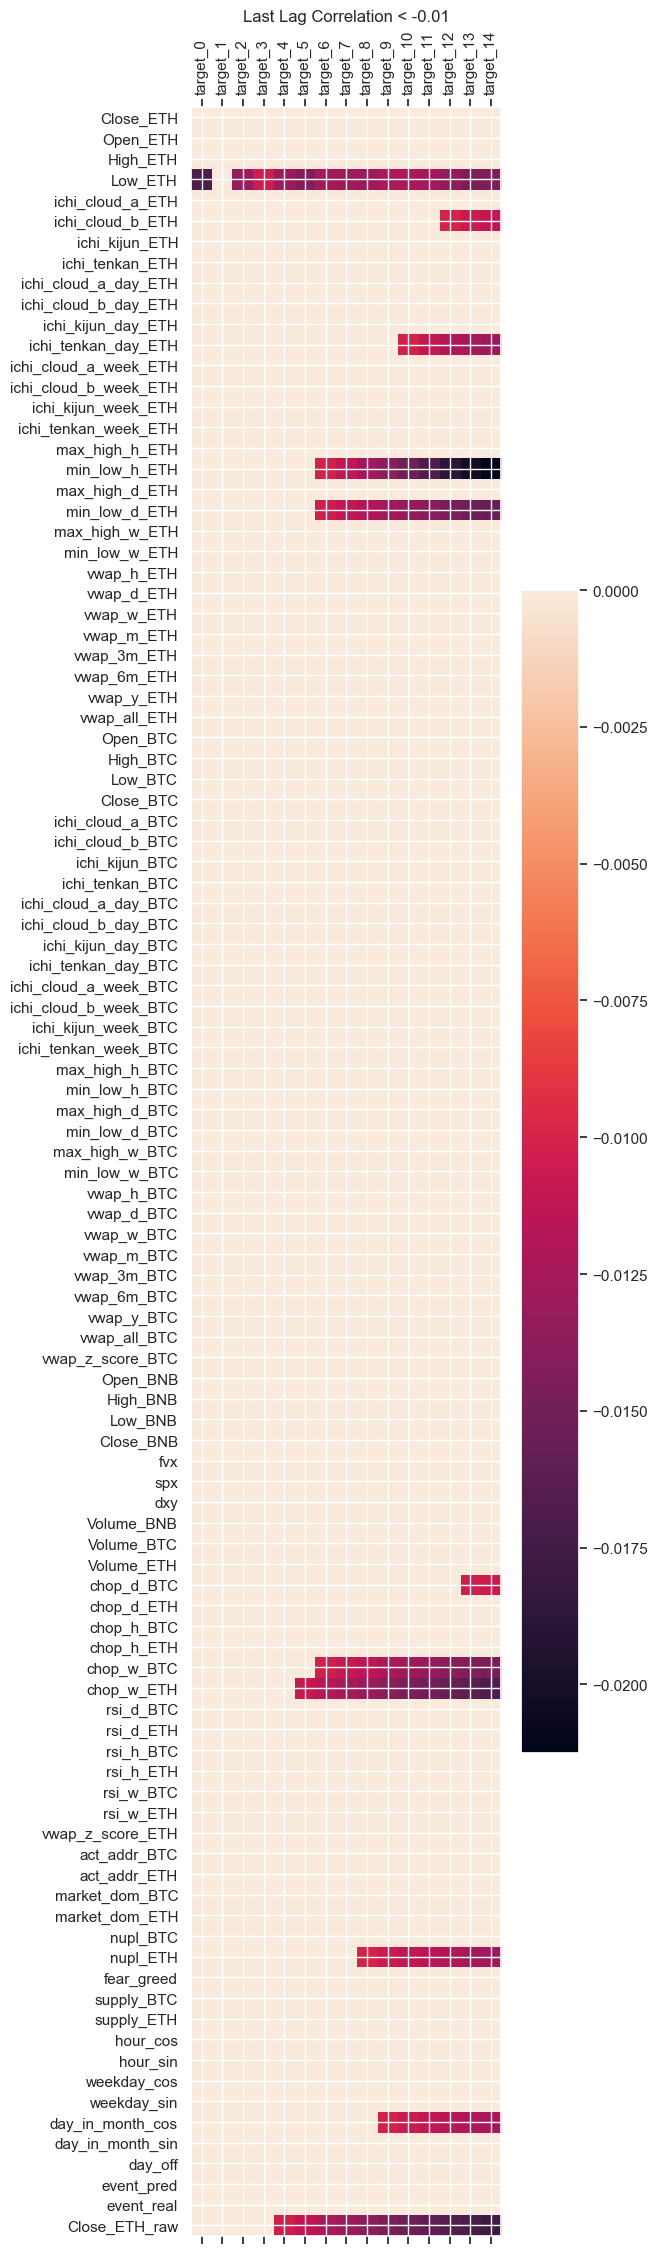

In [174]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.01, 0), 
          title="Last Lag Correlation < -0.01", 
          size=5)

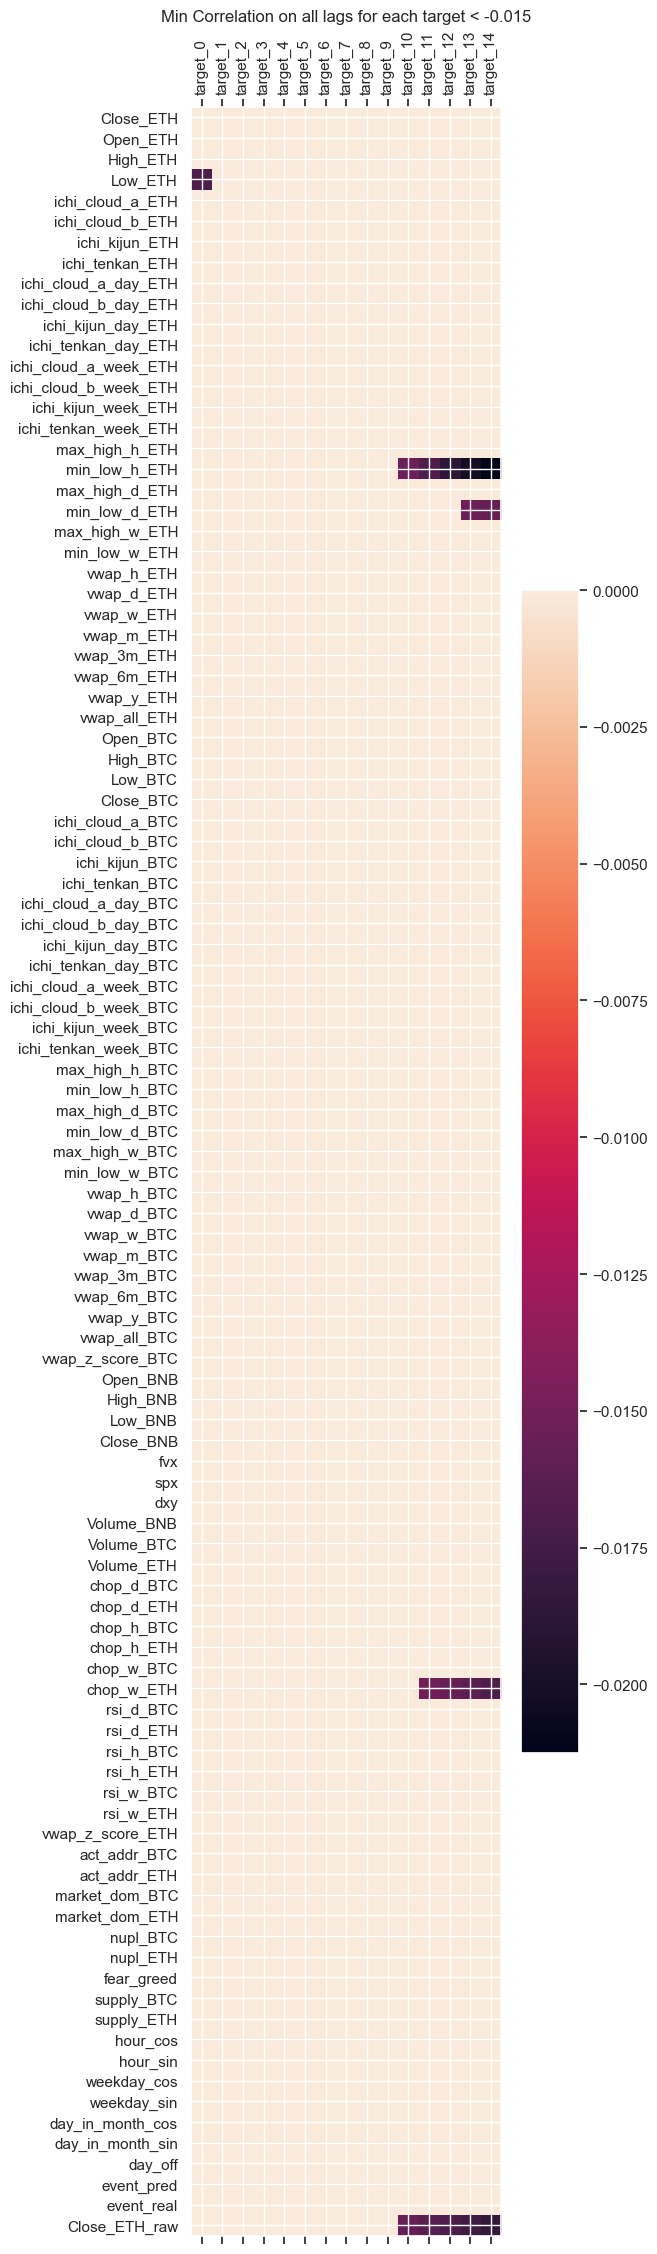

In [ ]:
fig = plot_corr(min_corr_matrix_targets.where(min_corr_matrix_targets < -0.015, 0),
                title="Min Correlation on all lags for each target < -0.015",
                size=5)

Text(0, 0.5, 'Min Correlation on all lags for each target < -0.015')

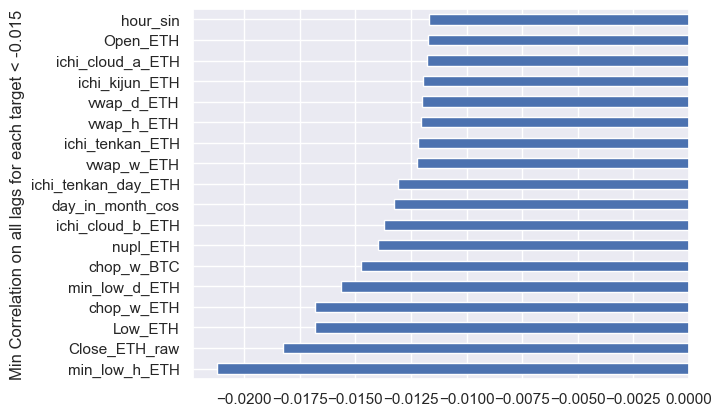

In [180]:
min_min_corr = min_corr_matrix_targets.min(axis=1).sort_values(ascending=True)
min_min_corr[min_min_corr.values<-0.011].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_ylabel("Min Correlation on all lags for each target < -0.015")

<Axes: >

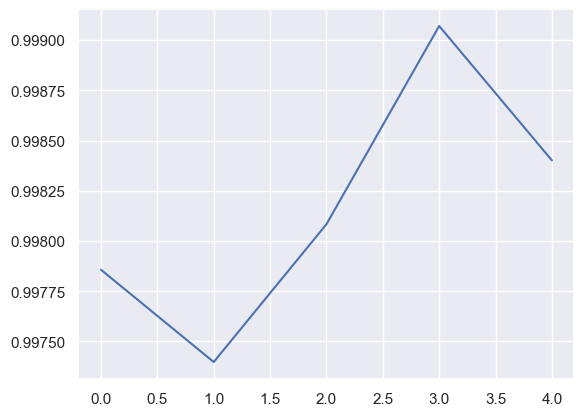

In [185]:
df["min_low_h_ETH"].head().plot()

In [186]:
df["min_low_h_ETH"].describe()

count    253677.000000
mean          0.995225
std           0.005330
min           0.847357
25%           0.993900
50%           0.996677
75%           0.998391
max           1.000000
Name: min_low_h_ETH, dtype: float64

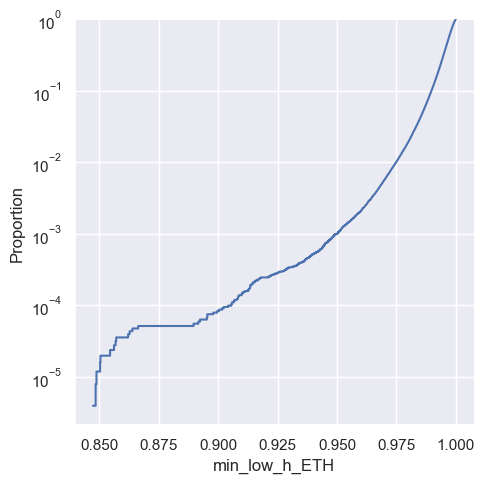

In [188]:
sns.displot(df, x="min_low_h_ETH", kind="ecdf", log_scale=(False, True))

In [254]:
list_level=["very_low", "low", "neutral"]
df["min_low_h_ETH_cat"] = "low"
df.loc[df["min_low_h_ETH"] < 0.995, "min_low_h_ETH_cat"] = "very_low"
df.loc[df["min_low_h_ETH"] > 0.998, "min_low_h_ETH_cat"] = "neutral"
df["min_low_h_ETH_cat"].value_counts()

min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

Text(0.5, 1.0, 'Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)')

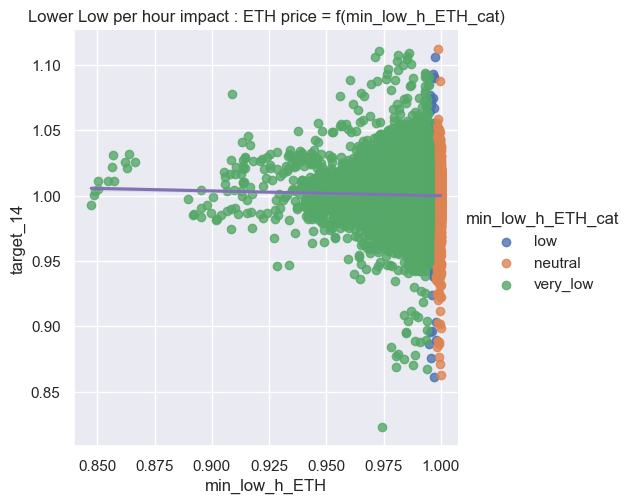

In [255]:
sns.lmplot(x="min_low_h_ETH", y="target_14", hue="min_low_h_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)")

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_62136/2612964428.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

<Figure size 500x400 with 0 Axes>

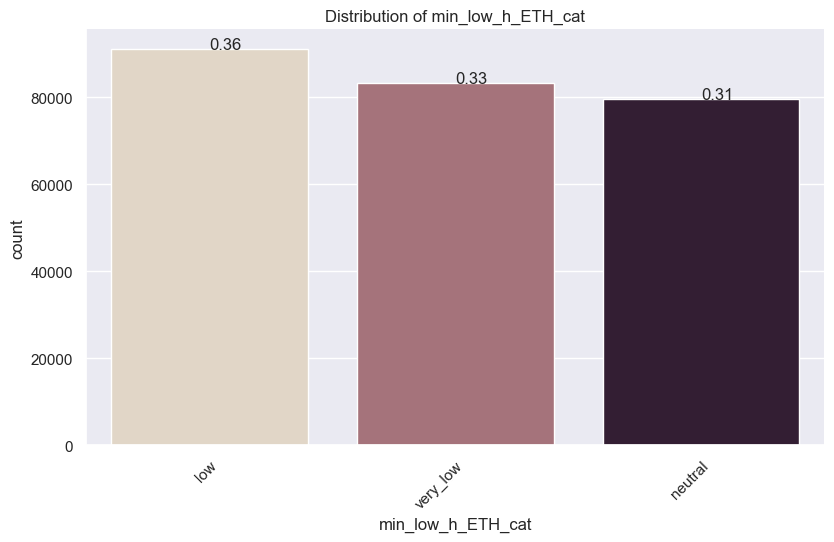

In [ ]:

plot_hist_cat(x="min_low_h_ETH_cat", data=df, title="Distribution of min_low_h_ETH_cat")

target_cat            down  neutral       up     Total
min_low_h_ETH_cat                                     
low                26637.0  36690.0  27687.0   91014.0
neutral            19038.0  38856.0  21585.0   79479.0
very_low           29301.0  24089.0  29794.0   83184.0
total              74976.0  99635.0  79066.0  253677.0
xi_n =  151.74060064380734
chi2:
6903.191431206737
p:
0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


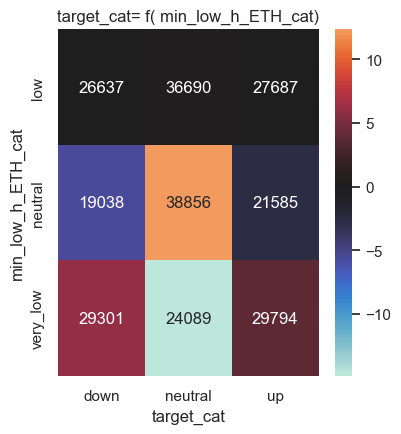

target_cat,down,neutral,up
min_low_h_ETH_cat,,,
low,26637,36690,27687
neutral,19038,38856,21585
very_low,29301,24089,29794


In [258]:
plot_cont(X="min_low_h_ETH_cat", Y="target_cat", data=df)

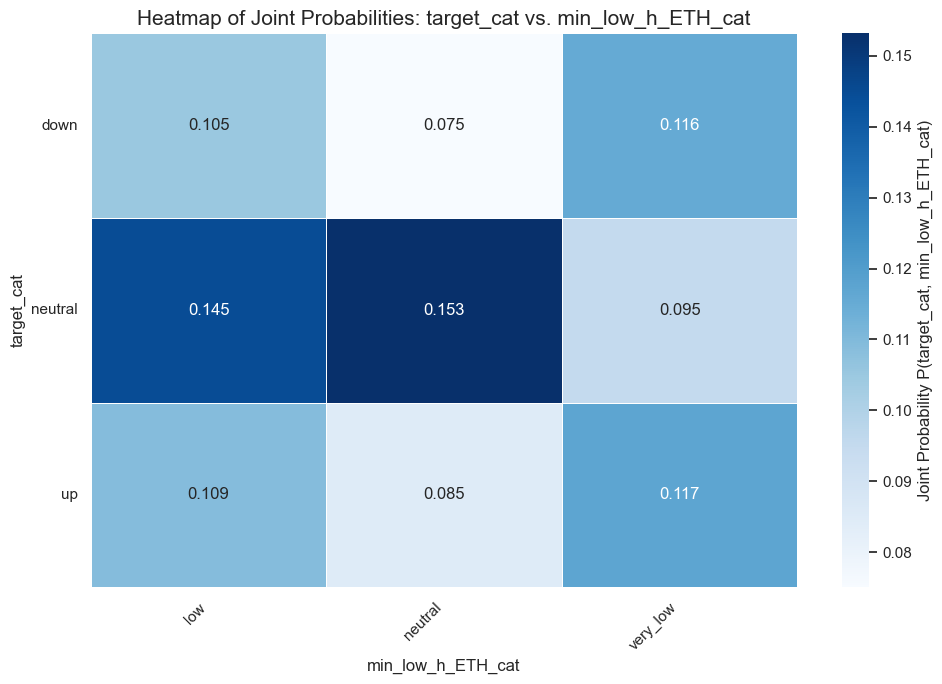

Joint Probability Table:
min_low_h_ETH_cat       low   neutral  very_low
target_cat                                     
down               0.105004  0.075048  0.115505
neutral            0.144633  0.153171  0.094959
up                 0.109143  0.085089  0.117449


In [259]:
probability_table = pd.crosstab(df['target_cat'], df['min_low_h_ETH_cat'], normalize=True)
# 2. Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    probability_table,
    annot=True,        # Show the probability values on the heatmap cells
    fmt=".3f",         # Format annotations to 3 decimal places
    cmap="Blues",      # Colormap (e.g., "Blues", "YlGnBu", "viridis")
    linewidths=.5,     # Add lines between cells for better separation
    cbar_kws={'label': 'Joint Probability P(target_cat, min_low_h_ETH_cat)'} # Label for the color bar
)

plt.title('Heatmap of Joint Probabilities: target_cat vs. min_low_h_ETH_cat', fontsize=15)
plt.ylabel('target_cat', fontsize=12)
plt.xlabel('min_low_h_ETH_cat', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if long
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Display the probability table (optional)
print("Joint Probability Table:")
print(probability_table)

In [219]:
probability_table.sum().sum()

np.float64(1.0)

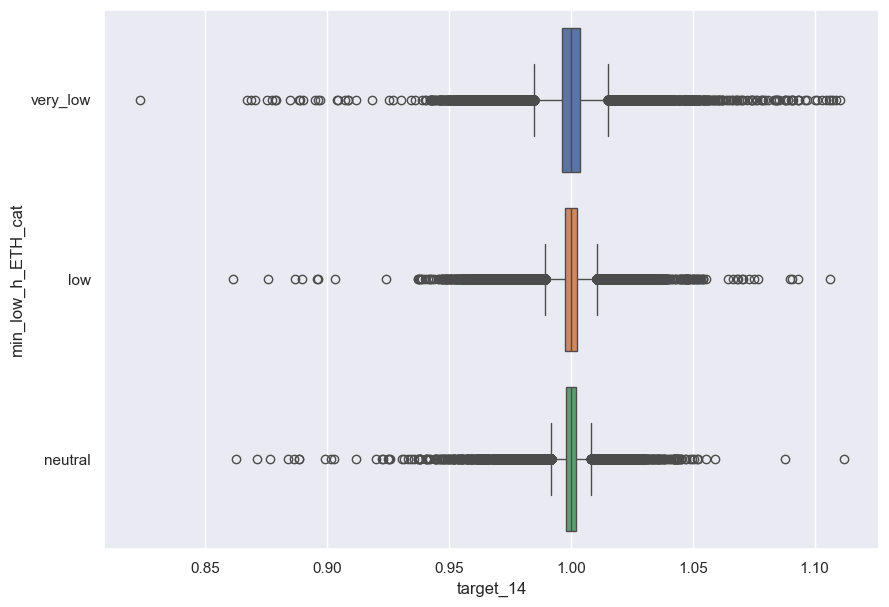

In [260]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="min_low_h_ETH_cat", 
    hue="min_low_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
#ax.set_xlim([0.98,1.02])

In [261]:
df["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [262]:
df["target_1"].describe()

count    253677.000000
mean          1.000009
std           0.002652
min           0.907143
25%           0.998967
50%           1.000013
75%           1.001066
max           1.081058
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

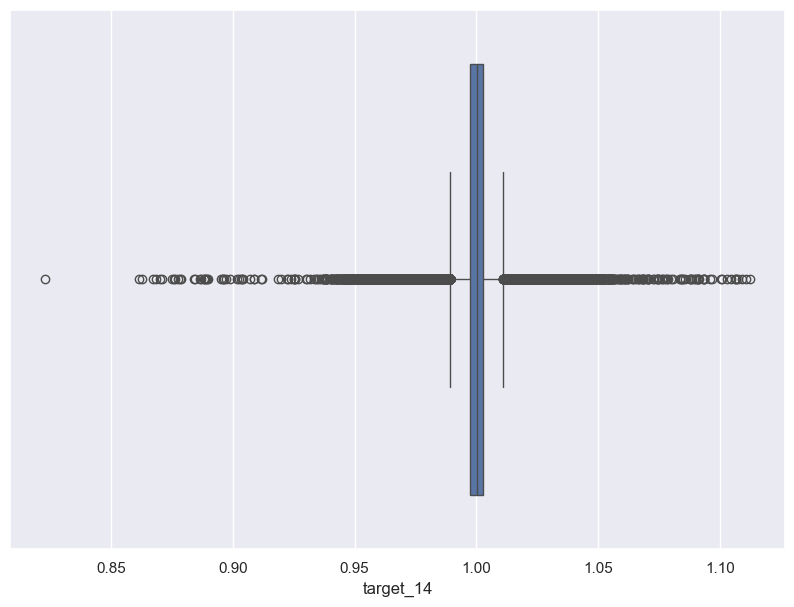

In [110]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

### Chi-2
Distrib are independent between inputs and target (target_14) ?  
Chi-2 must be low  
if not then we can use them as features  


In [ ]:
last_target = list_col_targets[-1]

In [340]:
df.filter(list_col_select)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,Close_ETH_raw
0,1.0,0.999782,1.000109,0.999774,0.999171,0.999736,0.998393,0.999464,2.024261,2.017807,...,2.588190e-01,0.965926,0.623490,-0.781832,0.97953,2.012985e-01,0.0,0.0,0.0,1194.540039
1,1.0,0.999548,1.000008,0.999540,0.998785,0.999276,0.998113,0.999184,2.023329,2.016878,...,6.123234e-17,1.000000,0.623490,-0.781832,0.97953,2.012985e-01,0.0,0.0,0.0,1195.089966
2,1.0,1.000084,1.000193,0.999841,0.998860,0.999351,0.998243,0.999477,2.023482,2.017030,...,6.123234e-17,1.000000,0.623490,-0.781832,0.97953,2.012985e-01,0.0,0.0,0.0,1195.000000
3,1.0,1.000770,1.000770,0.999900,0.999669,1.000113,0.999003,1.000239,2.025023,2.018567,...,6.123234e-17,1.000000,0.623490,-0.781832,0.97953,2.012985e-01,0.0,0.0,0.0,1194.089966
4,1.0,0.999330,1.000025,0.999330,0.999178,0.999443,0.998335,0.999569,2.023668,2.017215,...,6.123234e-17,1.000000,0.623490,-0.781832,0.97953,2.012985e-01,0.0,0.0,0.0,1194.890015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253672,1.0,0.998258,1.001698,0.997009,1.009059,1.012239,1.000323,1.000559,1.043299,1.026564,...,9.659258e-01,0.258819,-0.222521,-0.974928,1.00000,-2.449294e-16,0.0,0.0,0.0,2520.719971
253673,1.0,0.998554,1.001387,0.998451,1.006895,1.010775,0.998877,0.999113,1.041791,1.025079,...,9.659258e-01,0.258819,-0.222521,-0.974928,1.00000,-2.449294e-16,0.0,0.0,0.0,2524.370117
253674,1.0,1.004900,1.005056,0.999299,1.011829,1.015728,1.003772,1.004009,1.046896,1.030103,...,9.659258e-01,0.258819,-0.222521,-0.974928,1.00000,-2.449294e-16,0.0,0.0,0.0,2512.060059
253675,1.0,1.001168,1.001491,0.997621,1.011492,1.015731,1.004944,1.003987,1.048118,1.031306,...,9.659258e-01,0.258819,-0.222521,-0.974928,1.00000,-2.449294e-16,0.0,0.0,0.0,2509.129883


In [358]:
# find for all features the quantiles 0.10 and 0.90
# transpose the dataframe to have the features as columns
df_cont = df.filter(list_col_select + [last_target]).quantile([0.10, 0.90], axis=0)
df_cont = df_cont.T
# rename the columns
df_cont.columns = ["q10", "q90"]
# store nunique() in a new column
df_cont["nunique"] = df.filter(list_col_select + [last_target]).nunique()

df_cont

,q10,q90,nunique
Close_ETH,1.000000,1.000000,1
Open_ETH,0.998280,1.001714,76413
High_ETH,1.000016,1.002502,37382
Low_ETH,0.997419,0.999966,60295
ichi_cloud_a_ETH,0.990221,1.009114,171844
...,...,...,...
day_off,0.000000,0.000000,2
event_pred,0.000000,0.000000,3
event_real,0.000000,0.000000,3
Close_ETH_raw,1625.745996,3489.247998,135314


In [ ]:
def apply_cat(value, col_name):
    
    if value < df_cont.loc[col_name, "q10"]:
        return "low"
    elif value > df_cont.loc[col_name, "q90"]:
        return "high"
    else:
        return "neutral"
df["event_pred"].apply(lambda x: apply_cat(x, last_target)).value_counts()
     

event_pred
low        253652
neutral        25
Name: count, dtype: int64

In [361]:
df[last_target]

0         0.999858
1         0.998803
2         0.998594
3         1.000427
4         0.999732
            ...   
253672    0.993744
253673    0.988445
253674    0.996043
253675    0.995803
253676    1.007934
Name: target_14, Length: 253677, dtype: float64

In [ ]:
for I_past in range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df = pd.DataFrame(np.hstack((X_train_dat[:, I_past, :nb_plot], y_train)), 
        columns=list_col_corr)
    # create categories
    df["target_cat"] = "neutral"
    
    # calculate contingency table

    

In [ ]:
c, chi2, p, dof, expected = contingency_table(X, Y, data)

In [343]:

mquantiles(df["event_pred"], prob=[0.10, 0.90])

array([0., 0.])

In [346]:
df["event_pred"].nunique()

3

In [ ]:
df_cont